In [32]:
from QEB import *
from scipy.stats import chi2

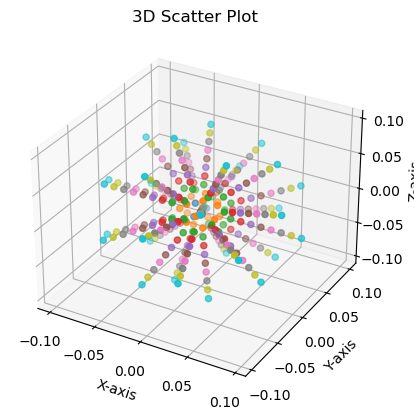

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# 创建3D图形对象
fig = plt.figure()
ax = plt.axes(projection='3d')
for i in range(1, 11):
    # 生成数据
    rad = 0.01 * i
    num_points = min(int((rad**2 / 0.01**2) * 4), 30)
    points = generate_points_on_sphere(radius=rad, num_points=num_points)
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]

    # 绘制3D散点图
    ax.scatter3D(x, y, z)

# 设置图形属性
ax.set_title('3D Scatter Plot')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# 显示图形
plt.show()


In [23]:
MAX_RAD = 1
wqeb = WQEB()
data = wqeb.read_data(
    root_map='./dataset/emd_11103.map', 
    root_pdb='./dataset/6z6u.pdb',
    atomic="CA",
    max_rad = MAX_RAD, 
    base_num_points=2, 
    max_points=100
    )

/home/bookbnnbnn/work/Academia Sinica/Empirical_Bayes_Q-scores/QEB/utils.py:71: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_df = gb_defected.mean().reset_index()


  0%|          | 0/4128 [00:00<?, ?it/s]

In [ ]:
NUM = 10
IN_GROUP_NUM = 50
mse_0 = np.zeros((NUM, NUM))
mse_1 = np.zeros((NUM, NUM))
mse_hyper = np.zeros((NUM, NUM))
ratio_to_weights = np.zeros((NUM, NUM))
ratio_to_contaminated = np.zeros((NUM, NUM))
similarity = np.zeros((NUM, NUM))
wqeb = WQEB()
for i in tqdm(range(NUM)):
    contained_ratio_beta = 0.05 * i
    for j in range(NUM):
        contained_ratio_data = 0.05 * j
        wqeb.create_data(
            group_num=1, 
            group_name=["A"], 
            contained_ratio_data=contained_ratio_data, 
            contained_ratio_beta=contained_ratio_beta, 
            in_group_num=IN_GROUP_NUM
            )
        wqeb.paramters_initial()
        wqeb.algorithm_iter(iter_num=20, alpha=contained_ratio_data, gamma=contained_ratio_beta, verbose=False)
        mse_0[i][j], mse_1[i][j] = np.mean((wqeb.betas["A"] - wqeb.betas_WEB["A"])**2, axis=0)
        mse_hyper[i][j] = np.sum((wqeb.mus["A"] - wqeb.mus_mle["A"])**2) / 2
        ratio_to_weights[i][j] = np.mean(wqeb.lambdas["A"] / 500)
        ratio_to_contaminated[i][j] = np.median(wqeb.lambdas["A"][int(IN_GROUP_NUM * contained_ratio_data): ]) / np.median(wqeb.lambdas["A"][: int(IN_GROUP_NUM * contained_ratio_data)])
        similarity[i][j] = np.mean(wqeb.similarities["A"])

  0%|          | 0/10 [00:00<?, ?it/s]

/home/bookbnnbnn/miniconda3/envs/ai_cup3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bookbnnbnn/miniconda3/envs/ai_cup3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/bookbnnbnn/work/Academia Sinica/Empirical_Bayes_Q-scores/QEB/utils.py:559: RuntimeWarning: Mean of empty slice.
  mean_densities.append(densities_chosen.mean())


In [ ]:
# wqeb = WQEB()
# wqeb.create_data(
#             group_num=1, 
#             group_name=["A"], 
#             contained_ratio_data=0.14, 
#             contained_ratio_beta=0.2, 
#             in_group_num=1
#             )

In [ ]:
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
import numpy as np

def simulation_plot(data, zlabel, title, min_num=0, max_num=0.5):
    z = data
    nrows, ncols = z.shape
    x = np.linspace(min_num, max_num, ncols)
    y = np.linspace(min_num, max_num, nrows)
    x, y = np.meshgrid(x, y)

    # Set up plot
    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), constrained_layout=True)

    ls = LightSource(270, 45)
    # To use a custom hillshading mode, override the built-in shading and pass
    # in the rgb colors of the shaded surface calculated from "shade".
    rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
    surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                        linewidth=0, antialiased=False, shade=False)    
    ax.set_xlabel("Contaminated ratio of points")
    ax.set_ylabel("Contaminated ratio of betas")
    ax.set_zlabel(zlabel, rotation=90, labelpad=-0.6)
    ax.dist = 11
    # ax.zaxis.labelpad = -0.6
    plt.title(title)
    plt.savefig("../figures/" + title)
    plt.show()

/tmp/ipykernel_10386/1732115093.py:26: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


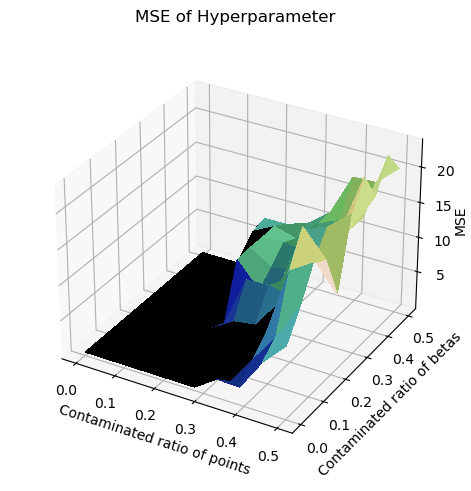

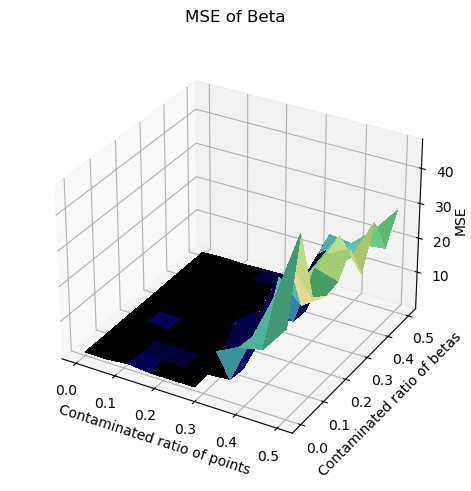

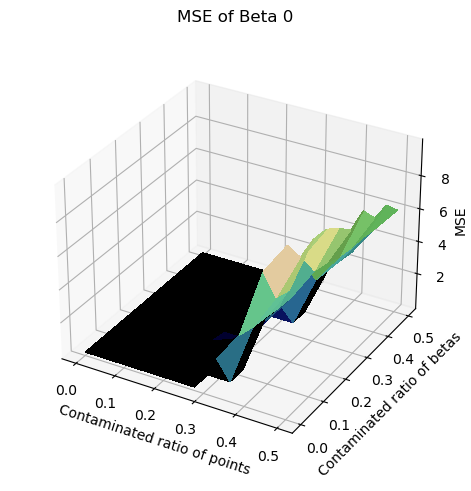

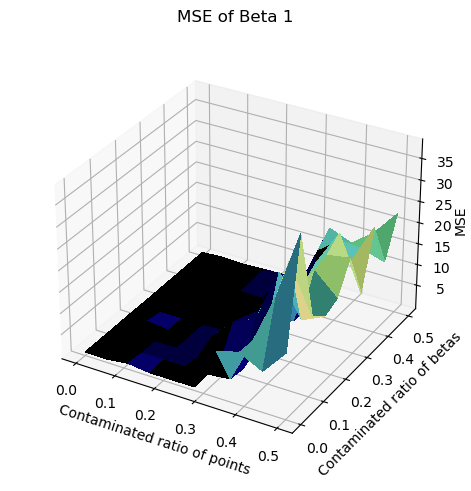

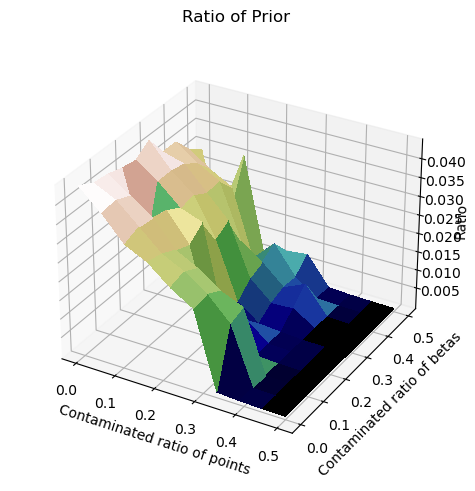

In [ ]:
simulation_plot(mse_hyper, "MSE", "MSE of Hyperparameter")
simulation_plot(mse_0 + mse_1, "MSE", "MSE of Beta")
simulation_plot(mse_0, "MSE", "MSE of Beta 0")
simulation_plot(mse_1, "MSE", "MSE of Beta 1")
simulation_plot(ratio_to_weights, "Ratio", "Ratio of Prior")
# simulation_plot(A, "Ratio", "Ratio of Contaminated Data")
# simulation_plot(similarity, "Similarity", "Fitted Similarity")

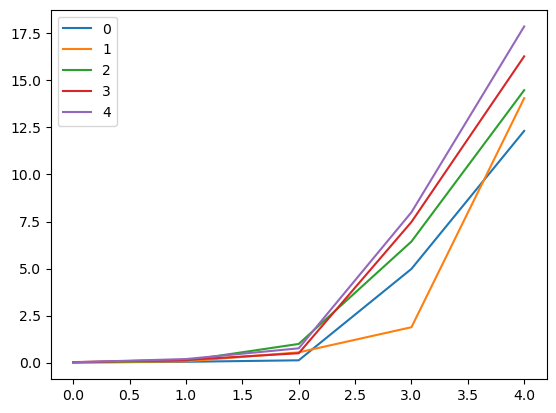

In [ ]:
for i in range(NUM):
    plt.plot(mse_0[i], label=i)
plt.legend()

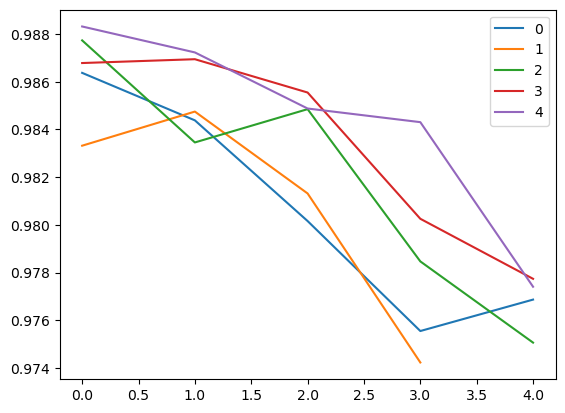

In [ ]:
for i in range(NUM):
    plt.plot(similarity[i], label=i)
plt.legend()

In [2]:
wqeb = WQEB()
data = wqeb.create_data(group_num=1, group_name=["A"], contained_ratio_data=0.2, contained_ratio_beta=0.2, in_group_num = 100)

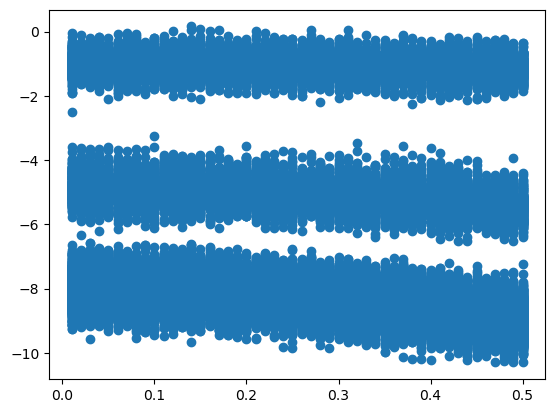

In [4]:
plt.scatter(wqeb.distances_to_center["A"].flatten(), wqeb.data_log["A"].flatten())

In [ ]:
num = int(490 * 0.2)
np.argpartition(np.array(A), num)[num:]

array([], shape=(0, 490), dtype=int64)

In [ ]:
np.argpartition(np.array(A), num)[num:]

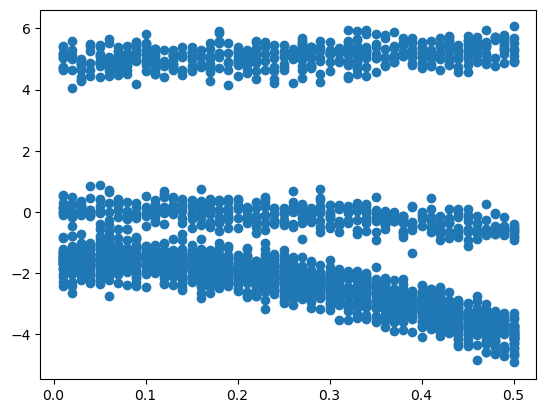

In [ ]:
plt.scatter(wqeb.distances_to_center["A"].flatten(), wqeb.data_log["A"].flatten())

In [24]:
_ = wqeb.paramters_initial()

In [25]:
betas_WEB, history = wqeb.algorithm_iter(max_iter=20, alpha=0.2, gamma=0.2, tol=1e-4)

  0%|          | 0/20 [00:00<?, ?it/s]

INFO:root:Iteration 0 finished. with difference: 2.500926701991935
INFO:root:Iteration 1 finished. with difference: 2.3763702925195913
INFO:root:Iteration 2 finished. with difference: 0.06650318093339212
INFO:root:Iteration 3 finished. with difference: 0.02428602389460873
INFO:root:Iteration 4 finished. with difference: 0.010791057864325104
INFO:root:Iteration 5 finished. with difference: 0.005377296504993765
INFO:root:Iteration 6 finished. with difference: 0.002853723272499291
INFO:root:Iteration 7 finished. with difference: 0.0015939167571967746
INFO:root:Iteration 8 finished. with difference: 0.0009284277698005392
INFO:root:Iteration 9 finished. with difference: 0.0005518374569373546
INFO:root:Iteration 10 finished. with difference: 0.0003297518927938276
INFO:root:Iteration 11 finished. with difference: 0.00020221067736471041
INFO:root:Iteration 12 finished. with difference: 0.00012752341641080888
INFO:root:Iteration 13 finished. with difference: 8.188500438650102e-05


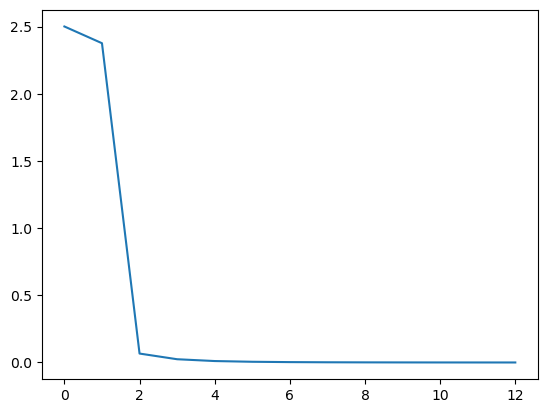

In [26]:
plt.plot(wqeb.beta_differences_histories)

In [27]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_scatter_with_concentric_circles(data, center_x, center_y, num_circles, spacing):
    fig, ax = plt.subplots()

    # 绘制散点图
    x = data[:, 0]
    y = data[:, 1]
    ax.scatter(x, y, color='blue', label='Betas WEB')

    # 绘制同心圆
    for i in range(1, num_circles + 1):
        radius = i * spacing
        circle = Circle((center_x, center_y), radius, fill=False, color='red', linestyle='dashed')
        ax.add_patch(circle)

    max_radius = num_circles * spacing + spacing
    # ax.set_xlim(center_x - max_radius, center_x + max_radius)
    # ax.set_ylim(center_y - max_radius, center_y + max_radius)
    ax.set_aspect('equal', adjustable='box')
    plt.gca().set_aspect('equal', adjustable='box')

    plt.title('Scatter Plot with Concentric Circles')
    plt.xlabel('Beta_0')
    plt.ylabel('Beta_1')
    plt.grid(True)
    plt.legend()
    plt.show()

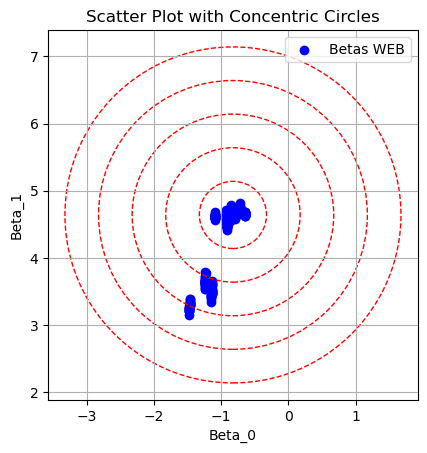

In [28]:
name = "ALA"
plot_scatter_with_concentric_circles(wqeb.betas_WEB[name], *wqeb.mus_mle[name], 5, 0.5)

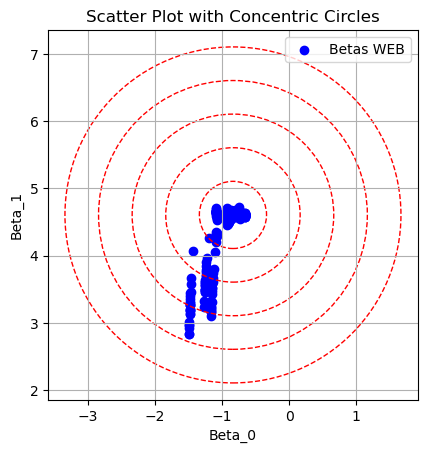

In [16]:
name = "ALA"
plot_scatter_with_concentric_circles(wqeb.betas_WEB[name], *wqeb.mus_mle[name], 5, 0.5)

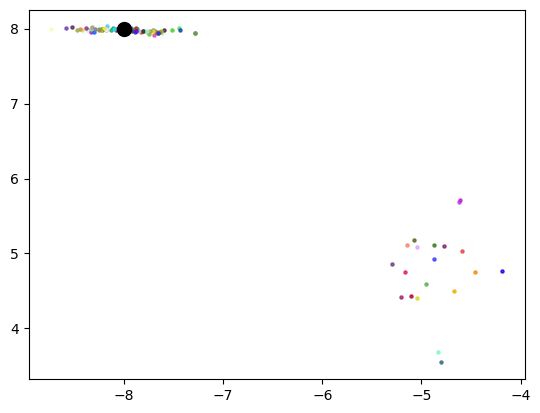

In [16]:
name = "A"
import matplotlib
# colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(wqeb.betas_WEB[name])))
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])for i in range(len(wqeb.betas_WEB[name]))]
for i in range(len(wqeb.betas_WEB[name])):
    plt.scatter(wqeb.betas_WEB[name][i][0], wqeb.betas_WEB[name][i][1], color=colors[i], alpha=0.8, s=5)
    # plt.scatter(wqeb.betas[name][i][0], wqeb.betas[name][i][1], color=colors[i], alpha=0.8, s=5)

# plt.scatter(wqeb.betas_WEB[name][:, 0], wqeb.betas_WEB[name][:, 1])
# plt.scatter(wqeb.betas[name][:, 0], wqeb.betas[name][:, 1])
plt.scatter(*wqeb.mus_mle[name], s=100, color="black")

In [29]:
sigma_hat0 = sum((wqeb.betas_WEB[name][:, 0] - wqeb.mus_mle[name][0])**2 * wqeb.lambdas[name]) / sum(wqeb.lambdas[name])
sigma_hat1 = sum((wqeb.betas_WEB[name][:, 1] - wqeb.mus_mle[name][1])**2 * wqeb.lambdas[name]) / sum(wqeb.lambdas[name])

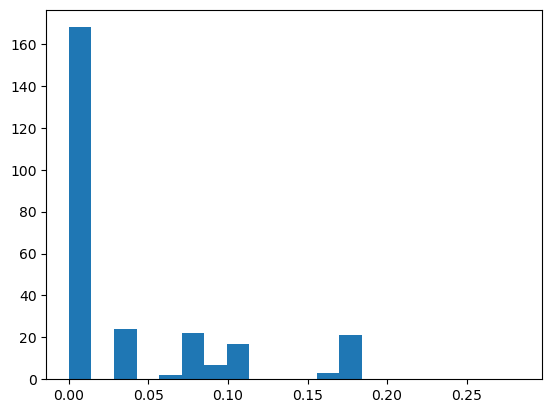

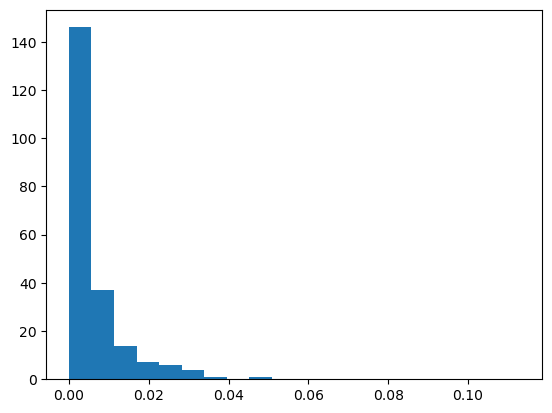

In [30]:
plt.hist((wqeb.betas_WEB[name][:, 0] - wqeb.mus_mle[name][0])**2, bins=[sigma_hat0 * i for i in range(0, 21) ])
plt.show()
plt.hist((wqeb.betas_WEB[name][:, 1] - wqeb.mus_mle[name][1])**2, bins=[sigma_hat1 * i for i in range(0, 21) ])
plt.show()

In [33]:
outliers0 = wqeb.betas_WEB[name][(wqeb.betas_WEB[name][:, 0] - wqeb.mus_mle[name][0])**2 / sigma_hat0 > chi2.interval(0.90, 1)[1]]
outliers1 = wqeb.betas_WEB[name][(wqeb.betas_WEB[name][:, 1] - wqeb.mus_mle[name][1])**2 / sigma_hat0 > chi2.interval(0.90, 1)[1]]

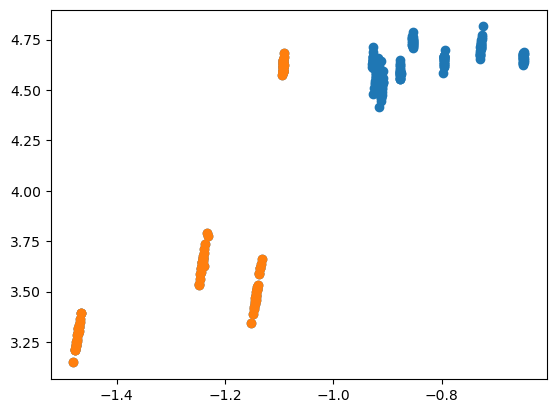

In [34]:
plt.scatter(wqeb.betas_WEB[name][:, 0], wqeb.betas_WEB[name][:, 1])
plt.scatter(outliers0[:, 0], outliers0[:, 1])

In [34]:
chi2.interval(0.90, 1)

(0.00393214000001952, 3.841458820694124)

In [31]:
from scipy.stats import multivariate_normal, chi2
_, margin = chi2.interval(0.95, 1)

(array([58., 14.,  8.,  9.,  3.,  2.,  1.,  0.,  1.,  0.,  0.,  2.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([8.51058650e-05, 5.81169466e-02, 1.16148787e-01, 1.74180628e-01,
        2.32212469e-01, 2.90244310e-01, 3.48276150e-01, 4.06307991e-01,
        4.64339832e-01, 5.22371673e-01, 5.80403513e-01, 6.38435354e-01,
        6.96467195e-01, 7.54499036e-01, 8.12530877e-01, 8.70562717e-01,
        9.28594558e-01, 9.86626399e-01, 1.04465824e+00, 1.10269008e+00,
        1.16072192e+00]),
 <BarContainer object of 20 artists>)

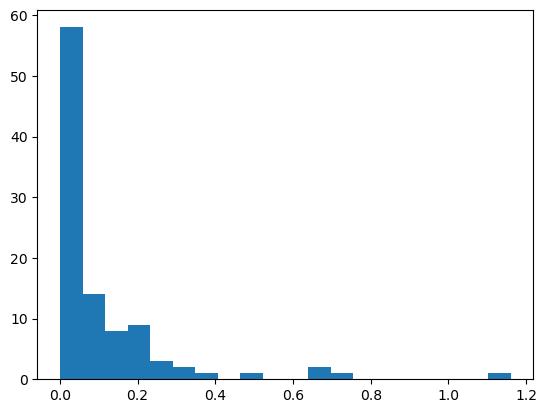

In [22]:
plt.hist(np.sum((wqeb.betas_WEB["A"] - wqeb.betas["A"])**2, axis=1), bins=20)

(array([20.,  0.,  0.,  1.,  2.,  8., 22., 27., 14.,  6.]),
 array([2.79032287e-15, 2.06231674e+00, 4.12463348e+00, 6.18695021e+00,
        8.24926695e+00, 1.03115837e+01, 1.23739004e+01, 1.44362172e+01,
        1.64985339e+01, 1.85608506e+01, 2.06231674e+01]),
 <BarContainer object of 10 artists>)

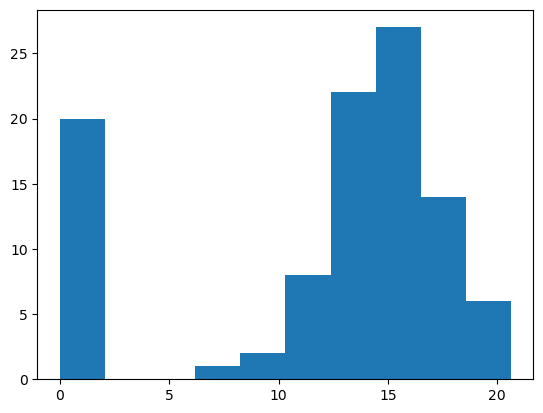

In [41]:
plt.hist(wqeb.lambdas["A"])

In [13]:
for name in wqeb.similarities:
    print(name, np.min(wqeb.similarities[name]))

ALA 0.9884185345647101
ARG 0.9912251542193831
ASN 0.9850779171431662
ASP 0.9852695468542382
CYS 0.9976799603199759
GLN 0.9939409371161662
GLU 0.9715228906075506
GLY 0.9898489930665725
HIS 0.9930077751324711
ILE 0.9875978772020331
LEU 0.9901323926469474
LYS 0.9912448011066985
MET 0.9881969846744308
PHE 0.996809699310572
PRO 0.9901884874301484
SER 0.8468394419534149
THR 0.9934035322846255
TRP 0.9940312063203764
TYR 0.9942163492236659
VAL 0.9936084231954321


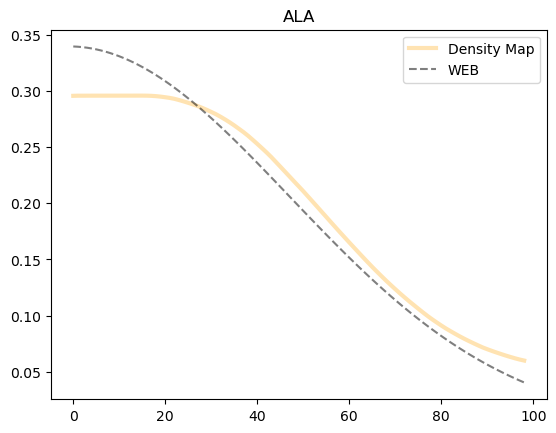

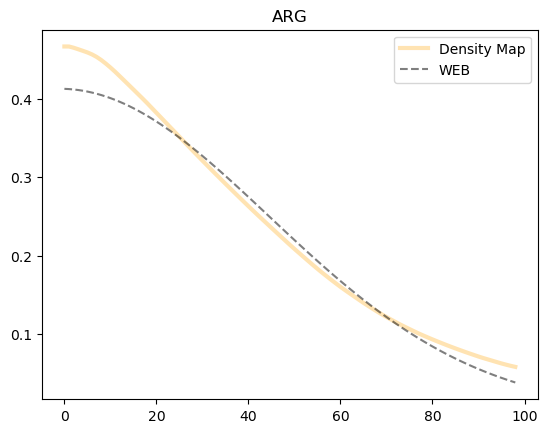

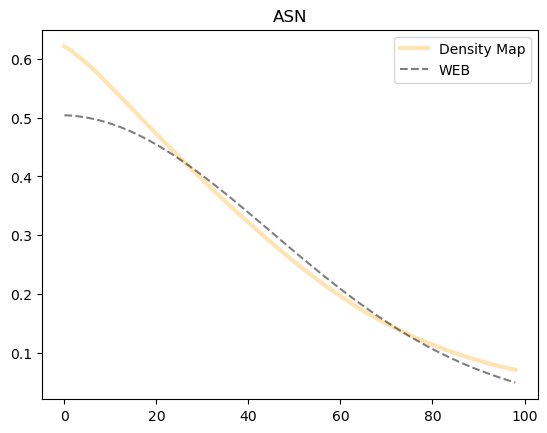

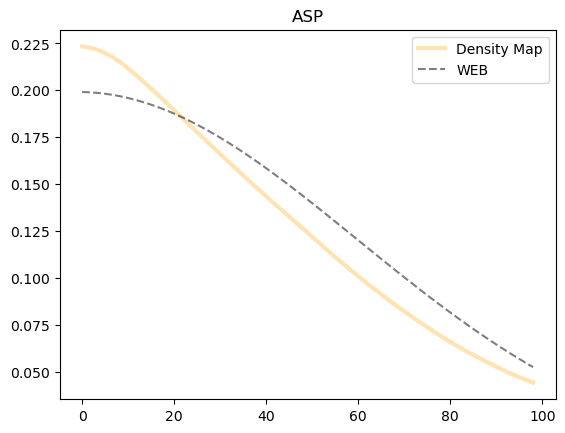

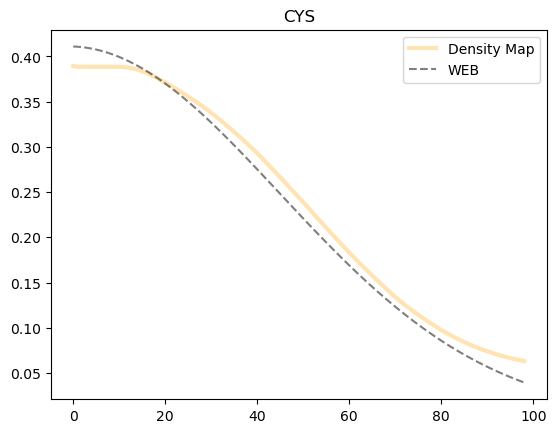

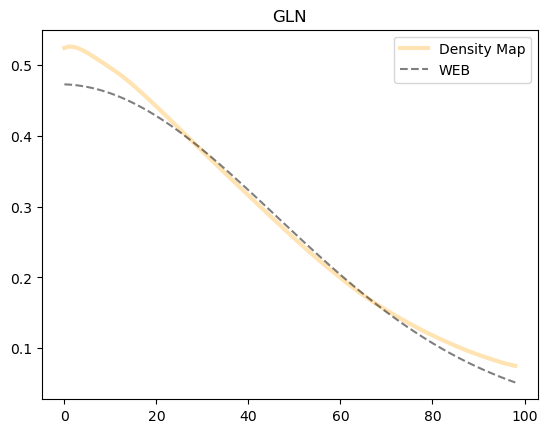

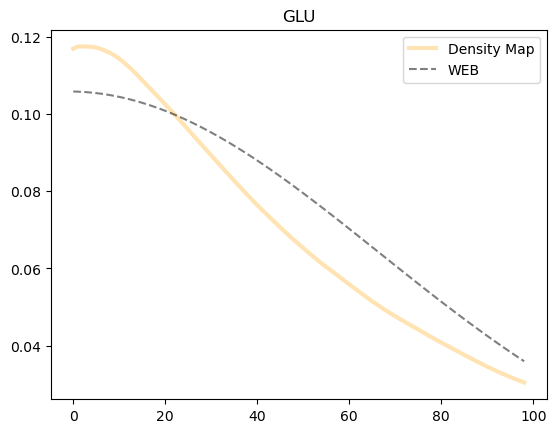

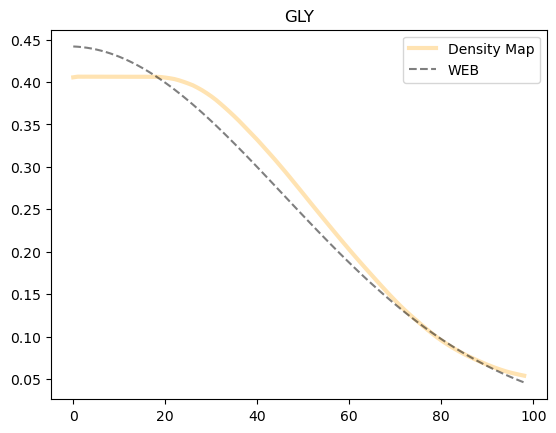

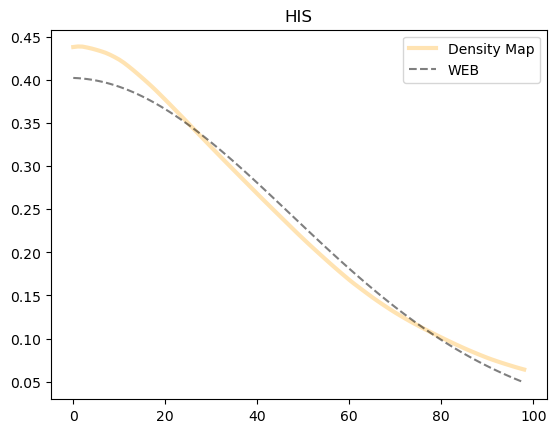

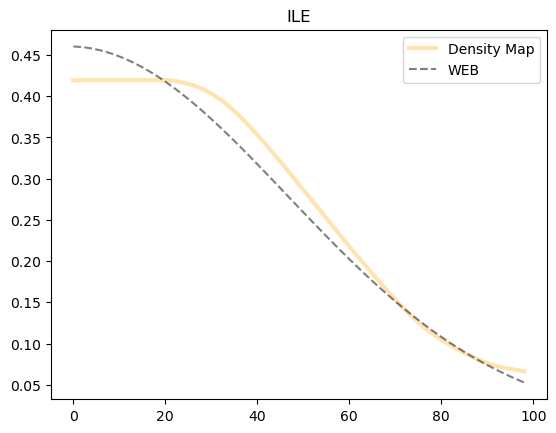

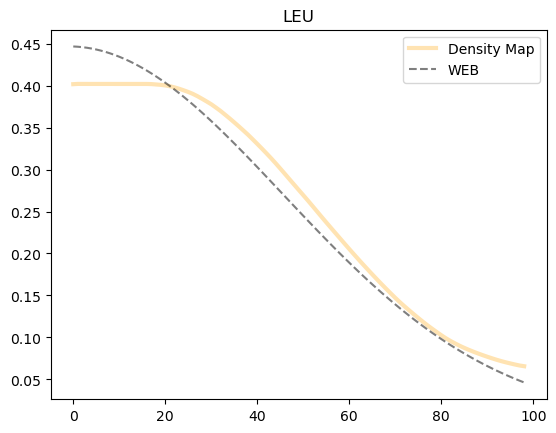

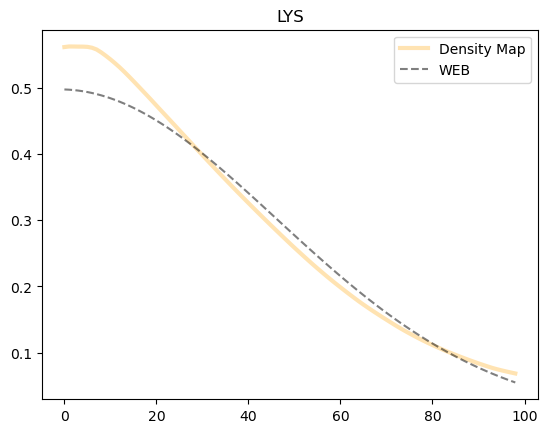

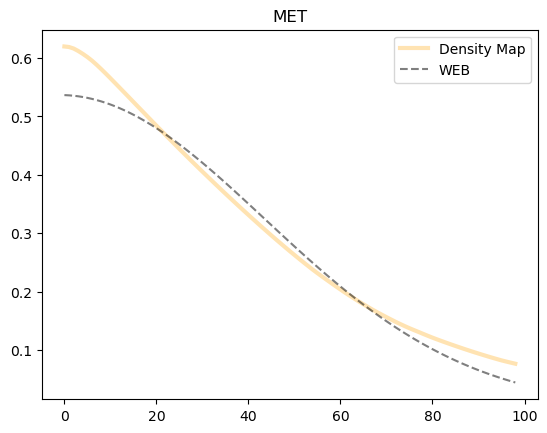

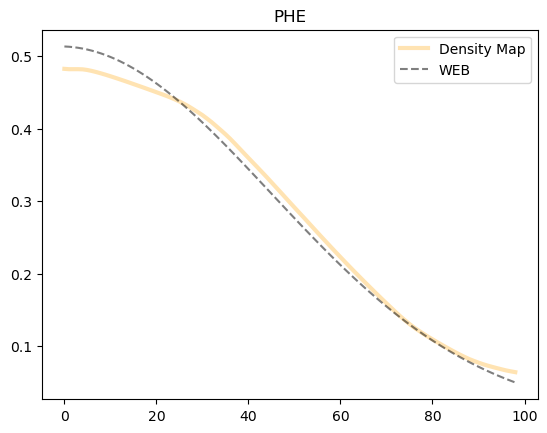

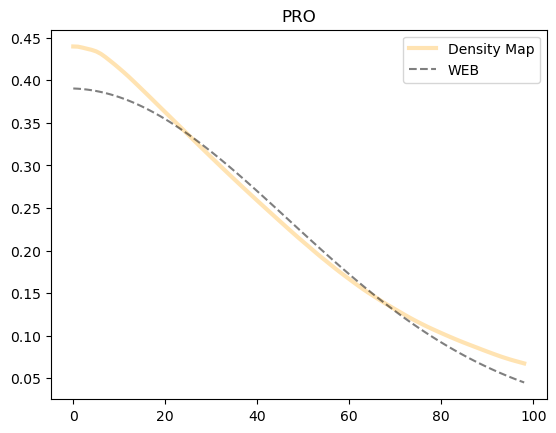

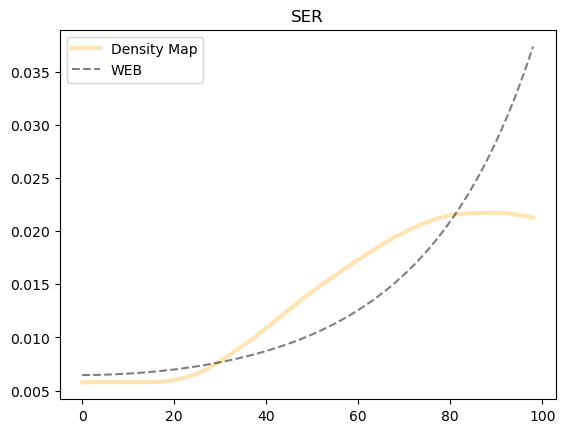

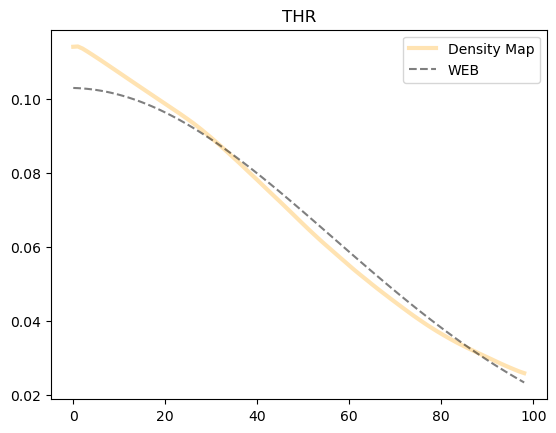

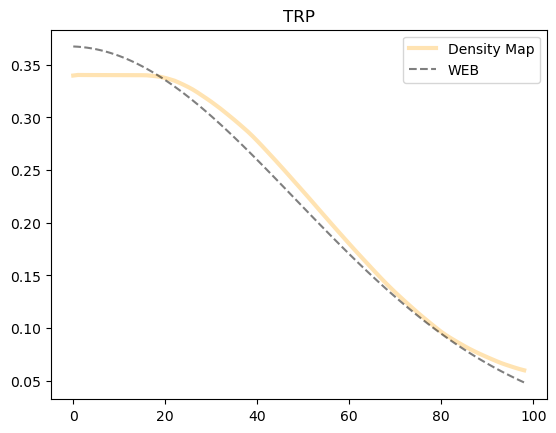

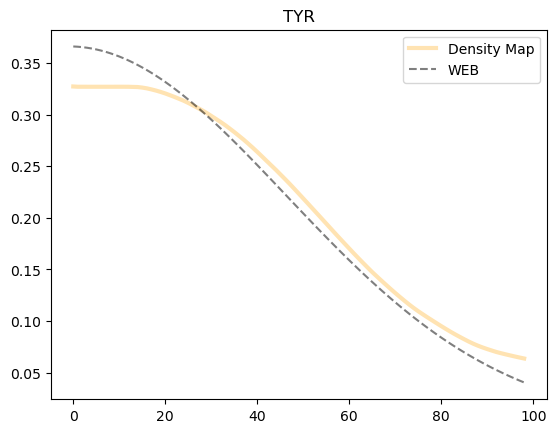

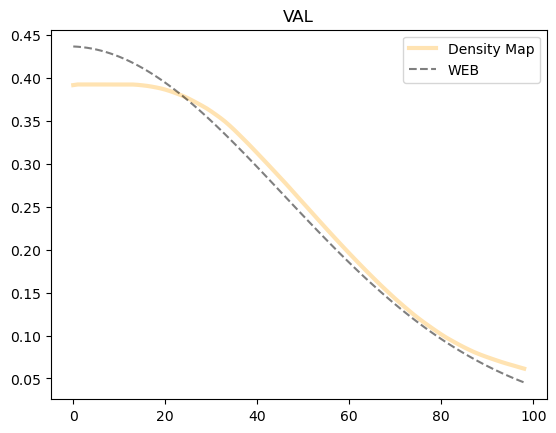

In [15]:
for name in wqeb.similarities:
    index = np.where(wqeb.similarities[name] == np.min(wqeb.similarities[name]))[0][0]
    plt.plot(wqeb.densities_data[name][index], linewidth=3, alpha=0.3, c="orange", label="Density Map")
    # plt.plot(wqeb.densities_betas_weighted[name][index], linestyle="--", c="blue", alpha=0.5, label="Weighted")
    plt.plot(wqeb.densities_betas_WEB[name][index], linestyle="--", c="black", alpha=0.5, label="WEB")
    plt.legend()
    plt.title(name)
    plt.show()

In [ ]:
max_radius = 1
gap = 0.01
subplots_num = len(densities_outliers)
nums = int(subplots_num / 5) + 1 if subplots_num % 5 != 0 else int(subplots_num / 5)
fig, axes = plt.subplots(nums, 5, figsize=(25, nums * 4), sharex=True, sharey=True, squeeze=False)
x = np.arange(0, max_radius - gap, gap)
length = len(x)

for times, name in enumerate(densities_outliers): 
    i = times // 5
    j = times % 5
    for density in wqeb.densities_data[name]:
        axes[i][j].plot(x, density[:length], linewidth=3, alpha=0.3, c="orange", label="map")
    for density_outliers in densities_outliers[name]:
        axes[i][j].plot(x, density_outliers[:length], linewidth=3, alpha=1, c="black", label="outliers")
    axes[i][j].set_title(name)

labels_handles = {
label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
}

fig.legend(
labels_handles.values(),
labels_handles.keys(),
loc = "upper center",
bbox_to_anchor = (0.1, 0.065),
bbox_transform = plt.gcf().transFigure,
)
fig.supxlabel('Radius')
fig.supylabel('Density')
plt.tight_layout()
fig.tight_layout(rect=(0.025, 0.03, 1, 1))
fig.savefig("../figures/outliers_beta1.png")

288

IndexError: index 58 is out of bounds for axis 0 with size 58

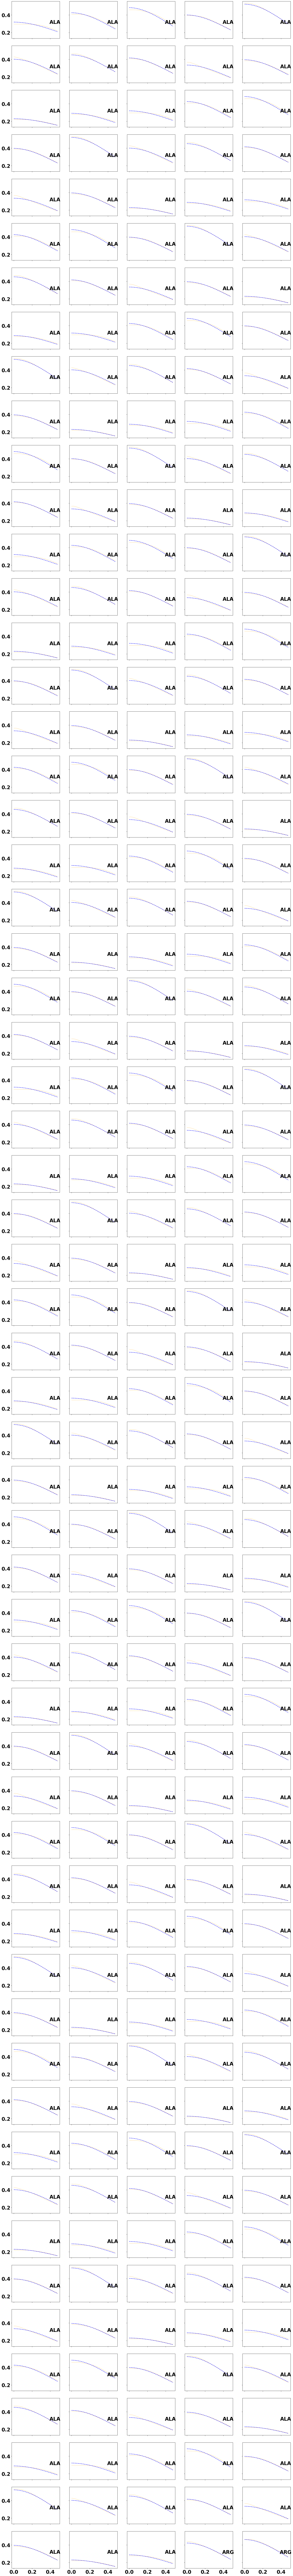

In [40]:
plot_density(wqeb.densities_data, [wqeb.densities_betas_WEB], 0.5, 0.01, labels=["WEB"], colors=["blue"], subplots_num=288, separated=True)
plt.savefig("../figures/densities_fitted_result")

In [ ]:
# lengths = 0
# for name, similarities in wqeb.similarities.items():
#     indexes = np.where(np.array(similarities) < 0.95)[0]
#     lengths += len(indexes)
#     for idx in indexes:
#         plt.plot(wqeb.densities_data[name][idx])
#         plt.plot(wqeb.densities_estimated[name][idx])
#         plt.show()
# # lengths

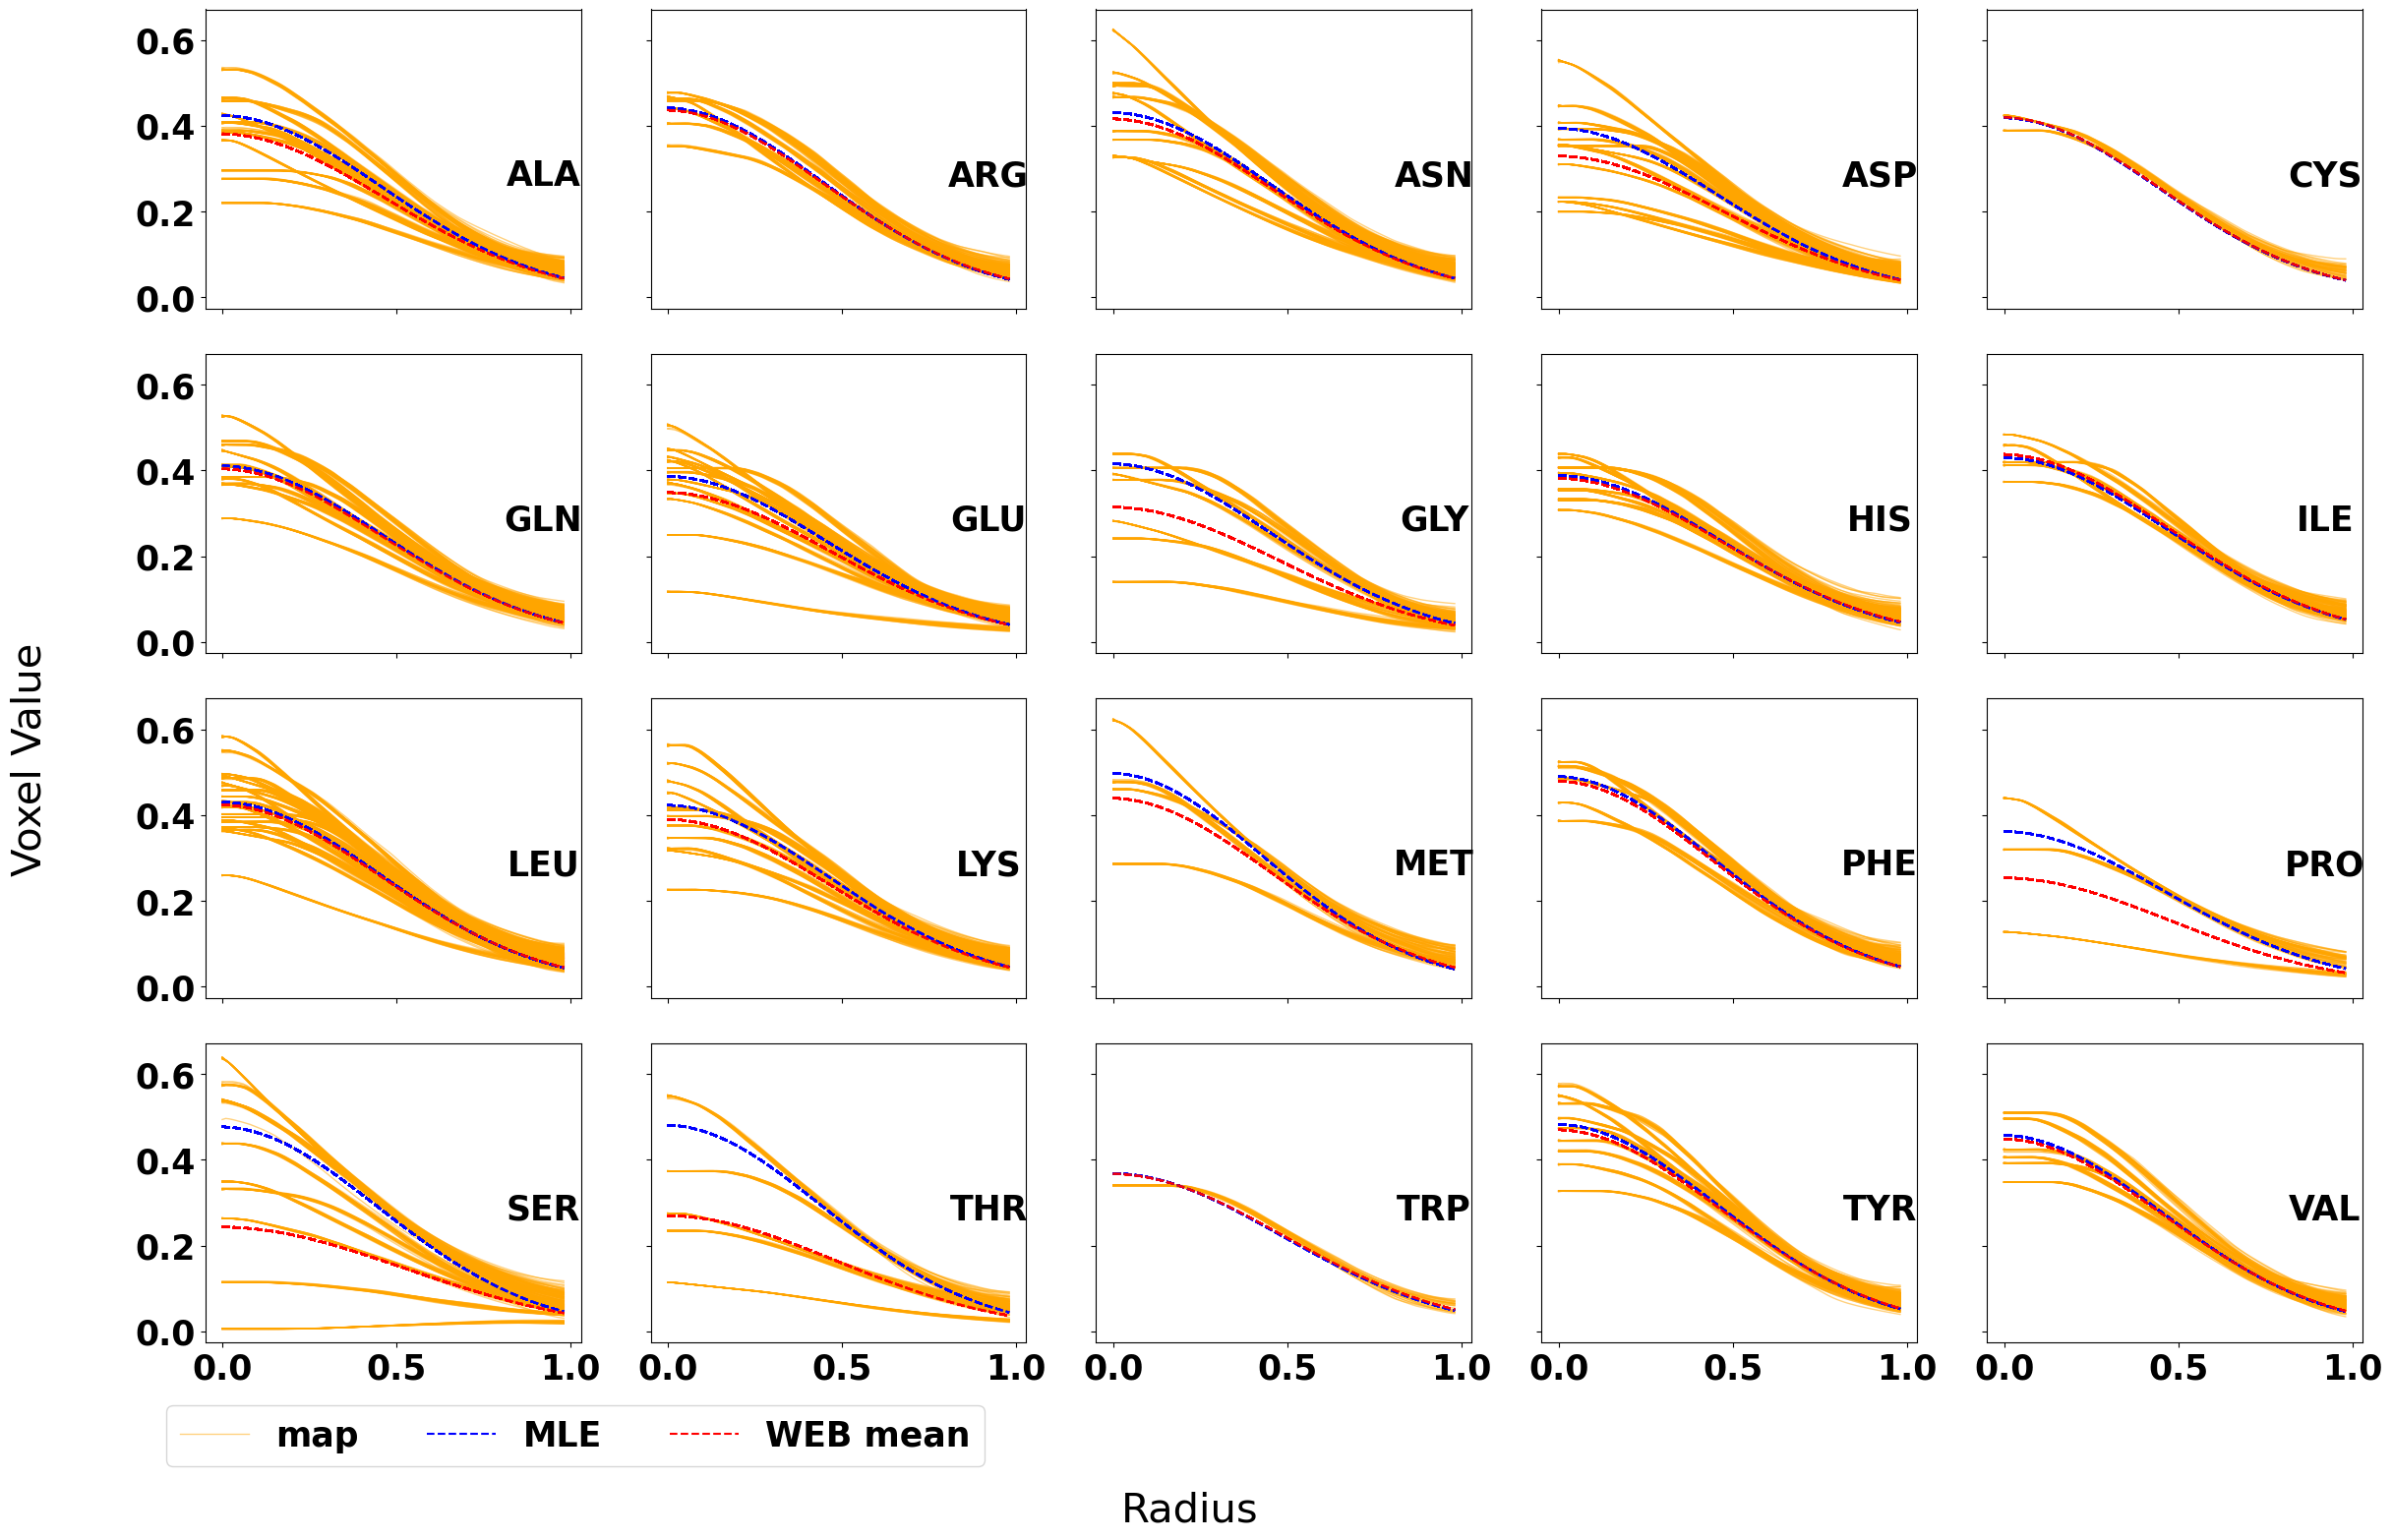

In [6]:
wqeb.plot_data(max_radius=1, gap=0.01, save=True)

In [ ]:
A = [np.diag(weights) for weights in wqeb.weight_matrixs["A"]]
df_A = pd.DataFrame(A).T
df_A.columns = [f"True Beta = {np.round(beta, 2)}" for beta in wqeb.betas["A"]]

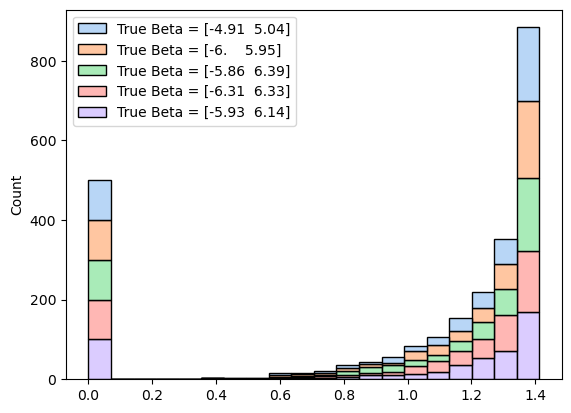

In [ ]:
import seaborn as sns
sns.histplot(data=df_A, stat="count", multiple="stack", kde=False, palette="pastel",
             element="bars", legend=True, bins = 20)
plt.savefig("../figures/weight_matrixs_A")

In [ ]:
B = [np.diag(weights) for weights in wqeb.weight_matrixs["B"]]
df_B = pd.DataFrame(B).T
df_B.columns = [f"True Beta = {np.round(beta, 2)}" for beta in wqeb.betas["B"]]

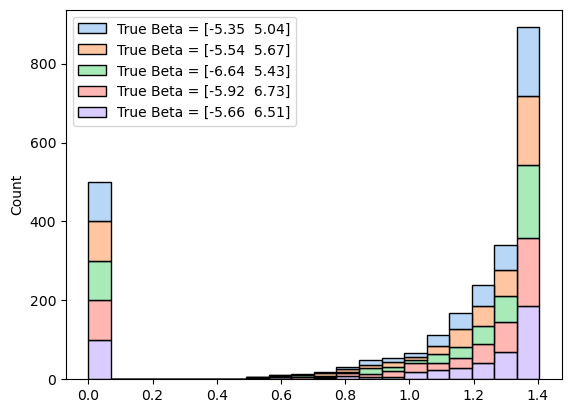

In [ ]:
import seaborn as sns
sns.histplot(data=df_B, stat="count", multiple="stack", kde=False, palette="pastel",
             element="bars", legend=True, bins = 20)
plt.savefig("../figures/weight_matrixs_B")

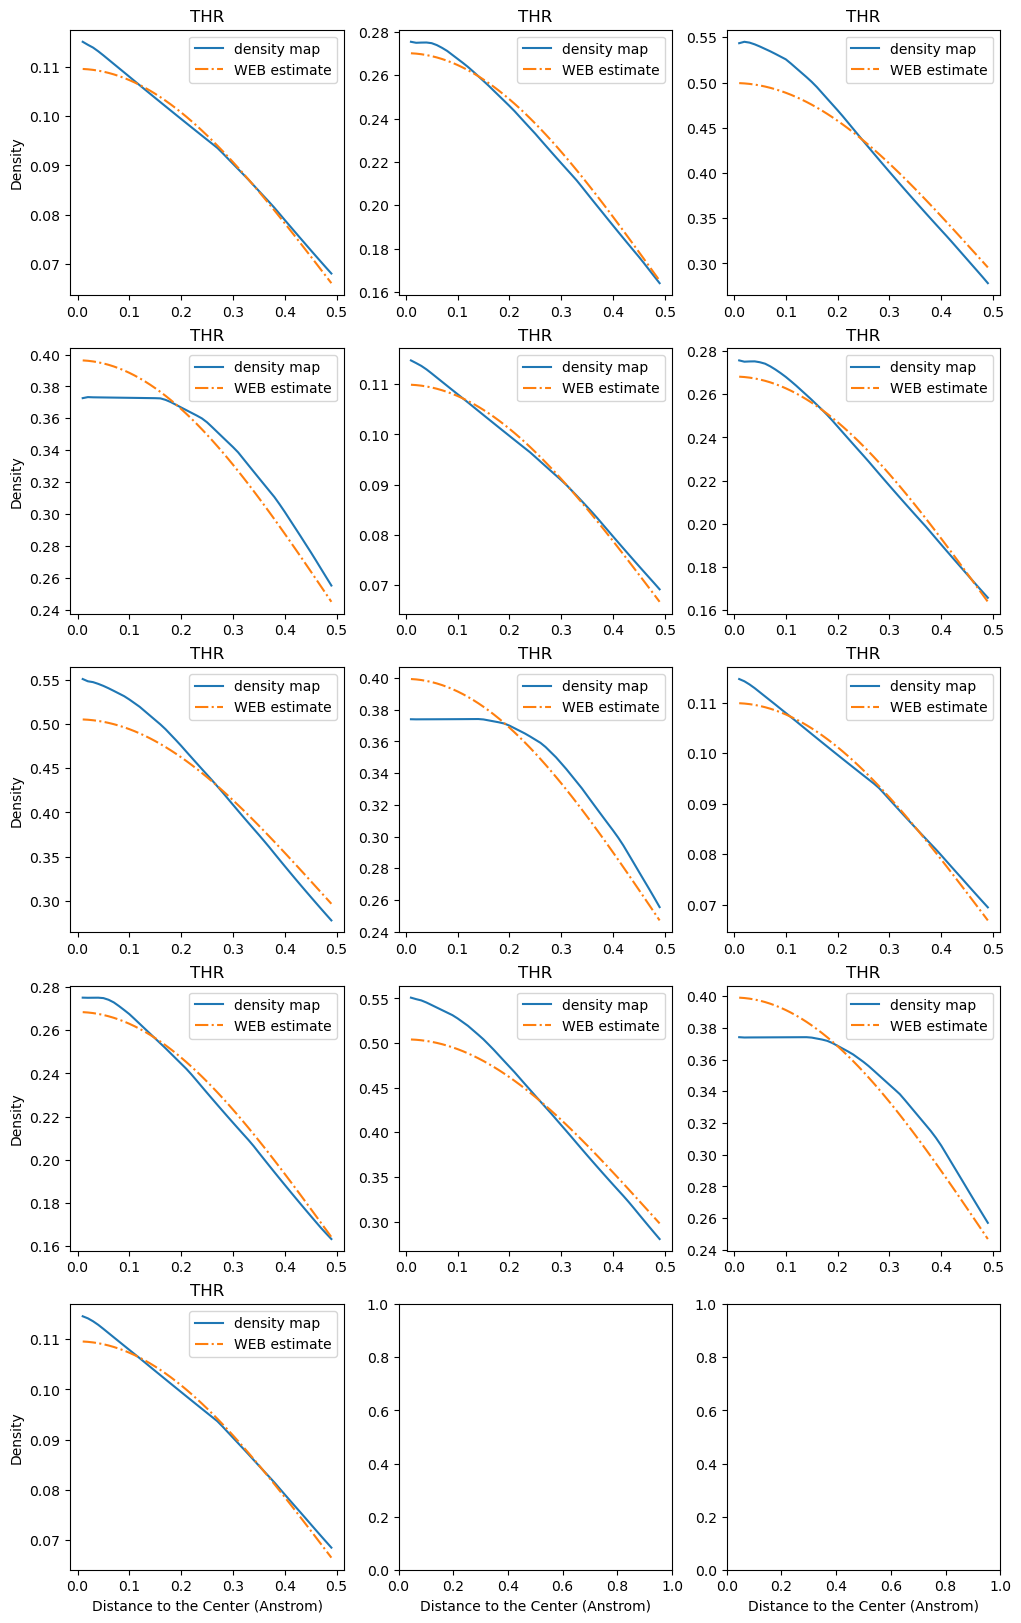

In [ ]:
wqeb.plot_data(max_rad=0.5, amino_acid="THR")

In [ ]:
wqeb.betas_em["SER"]

array([[-5.08919194, -3.30185218],
       [-1.32173519,  4.11898888],
       [-1.05466318,  4.53342354],
       [-0.71610258,  6.29323913],
       [-0.61926832,  4.87115188],
       [-0.64513169,  5.48097793],
       [-0.67640057,  4.8604109 ],
       [-1.00142459,  4.63278871],
       [-2.1433245 ,  2.91007488],
       [-5.07206776, -2.93671399],
       [-1.3323207 ,  4.1319605 ],
       [-1.04401488,  4.58074366],
       [-0.60367595,  4.80365695],
       [-0.63227357,  4.91581785],
       [-0.65875689,  4.82894882],
       [-0.68059605,  4.84495651],
       [-1.00594942,  4.57903772],
       [-2.15538006,  3.21356017],
       [-5.08169156, -2.98409614],
       [-1.33304785,  4.14228108],
       [-1.07024493,  4.24843186],
       [-0.6312188 ,  4.93481908],
       [-0.6163128 ,  5.18831979],
       [-0.65807955,  4.8179204 ],
       [-0.68652421,  4.85445868],
       [-1.01682513,  4.64608568],
       [-2.1755398 ,  2.82559803],
       [-5.07745883, -2.55374332],
       [-1.36205814,

(array([[ 24.,   0.,  48., 168.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  19.,   5.,   0.,   0.,  19.,  29., 156.,   7.,   5.]]),
 array([-5.17909051, -3.83753811, -2.49598571, -1.15443331,  0.18711909,
         1.52867149,  2.87022389,  4.21177629,  5.5533287 ,  6.8948811 ,
         8.2364335 ]),
 <a list of 2 BarContainer objects>)

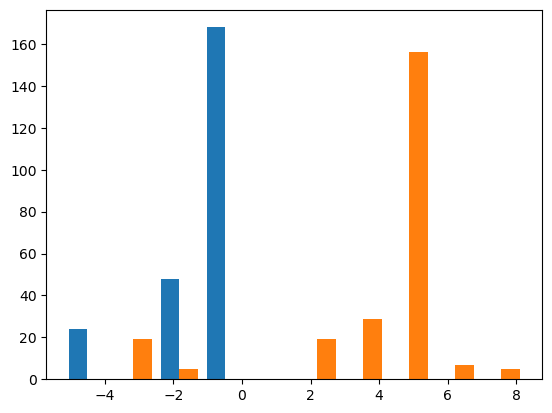

In [ ]:
plt.hist(wqeb.betas_em["SER"])

In [ ]:
wqeb.mus_mle

{'ALA': array([-0.87935299,  4.59410953]),
 'ARG': array([-0.84344561,  4.84463408]),
 'ASN': array([-0.72014312,  4.6550548 ]),
 'ASP': array([-0.9941492 ,  4.20429072]),
 'CYS': array([-0.88433208,  4.69011994]),
 'GLN': array([-0.92733641,  4.49019502]),
 'GLU': array([-0.90978788,  4.5570684 ]),
 'GLY': array([-0.86258705,  4.53200383]),
 'HIS': array([-0.9932477 ,  4.22573101]),
 'ILE': array([-0.84031063,  4.23895862]),
 'LEU': array([-0.81786762,  4.54576607]),
 'LYS': array([-0.85696994,  4.39877484]),
 'MET': array([-0.72395408,  5.02405128]),
 'PHE': array([-0.66816956,  4.65531942]),
 'PRO': array([-1.05815181,  4.31416084]),
 'SER': array([-0.6494596 ,  4.90463239]),
 'THR': array([-1.32856848,  3.76187006]),
 'TRP': array([-1.02199681,  3.79442259]),
 'TYR': array([-0.70586527,  4.47690943]),
 'VAL': array([-0.85377639,  4.46398003])}

In [ ]:
np.where(wqeb.betas_em["SER"][:, 0] < -1)

(array([  0,   1,   2,   7,   8,   9,  10,  11,  16,  17,  18,  19,  20,
         25,  26,  27,  28,  29,  35,  36,  37,  38,  43,  44,  45,  46,
         47,  53,  54,  55,  56,  61,  62,  63,  64,  65,  71,  72,  73,
         74,  79,  80,  81,  82,  83,  88,  89,  90,  91,  92,  97,  98,
         99, 100, 101, 106, 107, 108, 109, 110, 115, 116, 117, 118, 119,
        125, 126, 127, 128, 133, 134, 135, 136, 137, 143, 144, 145, 146,
        151, 152, 153, 154, 155, 160, 161, 162, 163, 164, 169, 170, 171,
        172, 173, 179, 180, 181, 182, 187, 188, 189, 190, 191, 196, 197,
        198, 199, 200, 205, 206, 207, 208, 209, 214, 215]),)

In [ ]:
name = "SER"
sigma = wqeb.sigmas_median[name] 
mean = wqeb.mus_mle[name]
betas = wqeb.betas_em[name]

In [ ]:
statistic_distances = []
for i in range(len(betas)):
    statistic_distances.append((betas - mean)[i].T @ np.linalg.inv(sigma_matrix) @ (betas - mean)[i] / len(betas))

In [ ]:
from scipy.stats import multivariate_normal, chi2
outliers = {}
statistic_distances = {}
_, margin = chi2.interval(0.95, 99)
# margin = 500
for name in wqeb.betas_em:
    outliers[name] = []
    statistic_distances[name] = []
    sigmas = wqeb.sigmas_median[name] 
    mean = wqeb.mus_mle[name]
    betas = wqeb.betas_em[name]
    lambdas = wqeb.lambdas[name]
    weight_matrixs = wqeb.weight_matrixs[name]
    datas = wqeb.densities_data[name]
    X = np.unique(wqeb.Xs_tilde[name][0], axis=0)
    # sigma_matrix = np.sum([lambdas[i] * (betas - mean)[i].reshape(-1, 1) @ (betas - mean)[i].reshape(-1, 1).T for i in range(len(betas))], axis=0) / np.sum(lambdas) 
    # sigma_matrix = np.sum([lambdas[i] * (X @ (betas - mean)[i].reshape(-1, 1)) @ (X @ (betas - mean)[i].reshape(-1, 1)).T for i in range(len(betas))], axis=0) / np.sum(lambdas) 
    for i in range(len(betas)):
        sigma_matrix = sigmas[i] * np.eye(len(X))
        # sigma_matrix = sigmas[i] * weight_matrixs[i]
        
        # statistic_distance = (betas - mean)[i].T @ np.linalg.inv(sigma_matrix) @ (betas - mean)[i] 
        Z = (X @ (betas - mean)[i]).reshape(-1, 1)
        # Z = (datas[i] - np.exp(X @ mean)).reshape(-1, 1)
        statistic_distance = (Z.T @ Z).flatten()
        # statistic_distance = (betas[i] - mean).T @np.linalg.inv(sigma[i] * np.eye(2)) @ (betas[i] - mean)
        statistic_distances[name].append(np.round(statistic_distance, 2))
        if statistic_distance > margin:
            outliers[name].append(i)

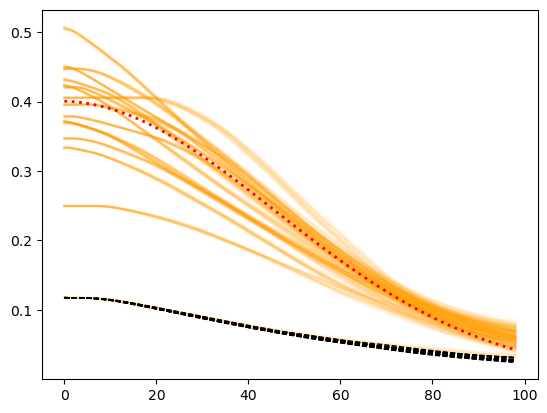

In [ ]:
name = "GLU"
outliers[name]
for idx, density in enumerate(wqeb.densities_data[name]):
    if idx in outliers[name]:
        plt.plot(density, color="black", linewidth=1, linestyle="--")
    else:
        plt.plot(density, color="orange", alpha=0.05)
        
plt.plot(wqeb.densities_mle[name], color="red", linewidth=2, linestyle=":")

In [ ]:
from scipy.stats import multivariate_normal, chi2
outliers = {}
statistic_distances = {}
# _, margin = chi2.interval(0.95, 2)
margin = 5
for name in wqeb.betas_em:
    outliers[name] = []
    statistic_distances[name] = []
    sigmas = wqeb.sigmas_median[name] 
    mean = wqeb.mus_mle[name]
    betas = wqeb.betas_em[name]
    lambdas = wqeb.lambdas[name]
    weight_matrixs = wqeb.weight_matrixs[name]
    datas_density = wqeb.densities_data[name]
    estimated_density = wqeb.densities_estimated[name]
    mle_density = wqeb.densities_mle[name]
    sigma_matrix = np.sum([lambdas[i] * (betas - mean)[i].reshape(-1, 1) @ (betas - mean)[i].reshape(-1, 1).T for i in range(len(betas))], axis=0) / np.sum(lambdas) 
    for i in range(len(betas)):
        # sigma_matrix = wqeb.sigmas_median[name][i] * np.eye(len(mle_density))
        # sigma_matrix = sigmas[i] * weight_matrixs[i]
        
        statistic_distance = (betas - mean)[i].T @ (betas - mean)[i] 
        # Z = (mle_density - datas_density[i]).reshape(-1, 1)
        # Z = (datas[i] - np.exp(X @ mean)).reshape(-1, 1)
        # statistic_distance = (Z.T @ Z).flatten()
        # statistic_distance = (betas[i] - mean).T @np.linalg.inv(sigma[i] * np.eye(2)) @ (betas[i] - mean)
        statistic_distances[name].append(np.round(statistic_distance, 2))
        if statistic_distance > margin:
            outliers[name].append(i)

In [ ]:
statistic_distances["LEU"][outliers["LEU"][0]]

7.26

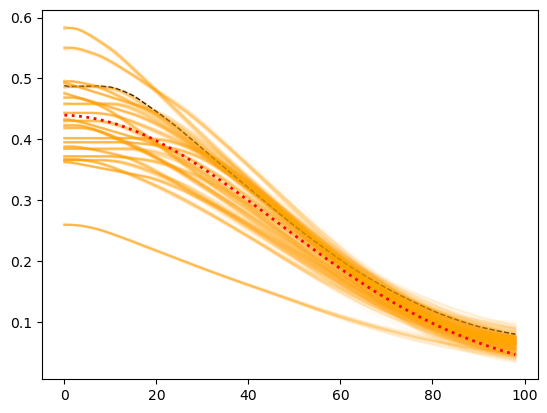

In [ ]:
name = "LEU"
outliers[name]
for idx, density in enumerate(wqeb.densities_data[name]):
    if idx in outliers[name]:
        plt.plot(density, color="black", linewidth=1, linestyle="--")
    else:
        plt.plot(density, color="orange", alpha=0.05)
        
plt.plot(wqeb.densities_mle[name], color="red", linewidth=2, linestyle=":")

In [ ]:
wqeb.betas_em["LEU"][outliers["LEU"]][0]

array([-0.71409269,  7.37403768])

In [ ]:
wqeb.betas_em["LEU"]

array([[-0.78153397,  4.59520102],
       [-0.75525353,  4.5582439 ],
       [-0.65301464,  4.64898867],
       ...,
       [-0.74007596,  4.55698579],
       [-0.74055978,  4.71315311],
       [-0.71811606,  4.54098962]])

In [ ]:
from scipy.stats import multivariate_normal, chi2
outliers = {}
statistic_distances = {}
_, margin = chi2.interval(0.95, 1)
# margin = 1
for name in wqeb.betas_weighted:
    outliers[name] = []
    statistic_distances[name] = []
    sigmas = wqeb.sigmas_median[name] 
    mean = wqeb.mus_mle[name]
    betas = wqeb.betas_weighted[name]
    lambdas = wqeb.lambdas[name]
    weight_matrixs = wqeb.weight_matrixs[name]
    datas_density = wqeb.densities_data[name]
    estimated_density = wqeb.densities_betas_weighted[name]
    mle_density = wqeb.densities_mle[name]
    # sigma_matrix = np.sum([lambdas[i] * (betas - mean)[i].reshape(-1, 1) @ (betas - mean)[i].reshape(-1, 1).T for i in range(len(betas))], axis=0) / np.sum(lambdas) 
    sigma_matrix = np.sum([(betas - mean)[i][0] ** 2 for i in range(len(betas))]) / (len(betas) - 1)
    for i in range(len(betas)):
        # sigma_matrix = wqeb.sigmas_median[name][i] * np.eye(len(mle_density))
        # sigma_matrix = sigmas[i] * weight_matrixs[i]
        
        statistic_distance = (betas - mean)[i][0] ** 2 / sigma_matrix
        # Z = (mle_density - datas_density[i]).reshape(-1, 1)
        # Z = (datas[i] - np.exp(X @ mean)).reshape(-1, 1)
        # statistic_distance = (Z.T @ Z).flatten()
        # statistic_distance = (betas[i] - mean).T @np.linalg.inv(sigma[i] * np.eye(2)) @ (betas[i] - mean)
        statistic_distances[name].append(np.round(statistic_distance, 2))
        if statistic_distance > margin:
            outliers[name].append(i)

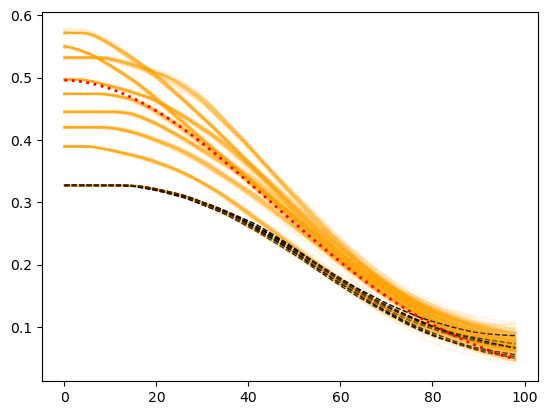

In [ ]:
name = "TYR"
outliers[name]
for idx, density in enumerate(wqeb.densities_data[name]):
    if idx in outliers[name]:
        plt.plot(density, color="black", linewidth=1, linestyle="--")
    else:
        plt.plot(density, color="orange", alpha=0.1)
        
plt.plot(wqeb.densities_mle[name], color="red", linewidth=2, linestyle=":")

In [ ]:
densities_outliers = {}
for name in wqeb.densities_data:
    densities_outliers[name] =wqeb.densities_data[name][outliers[name]]

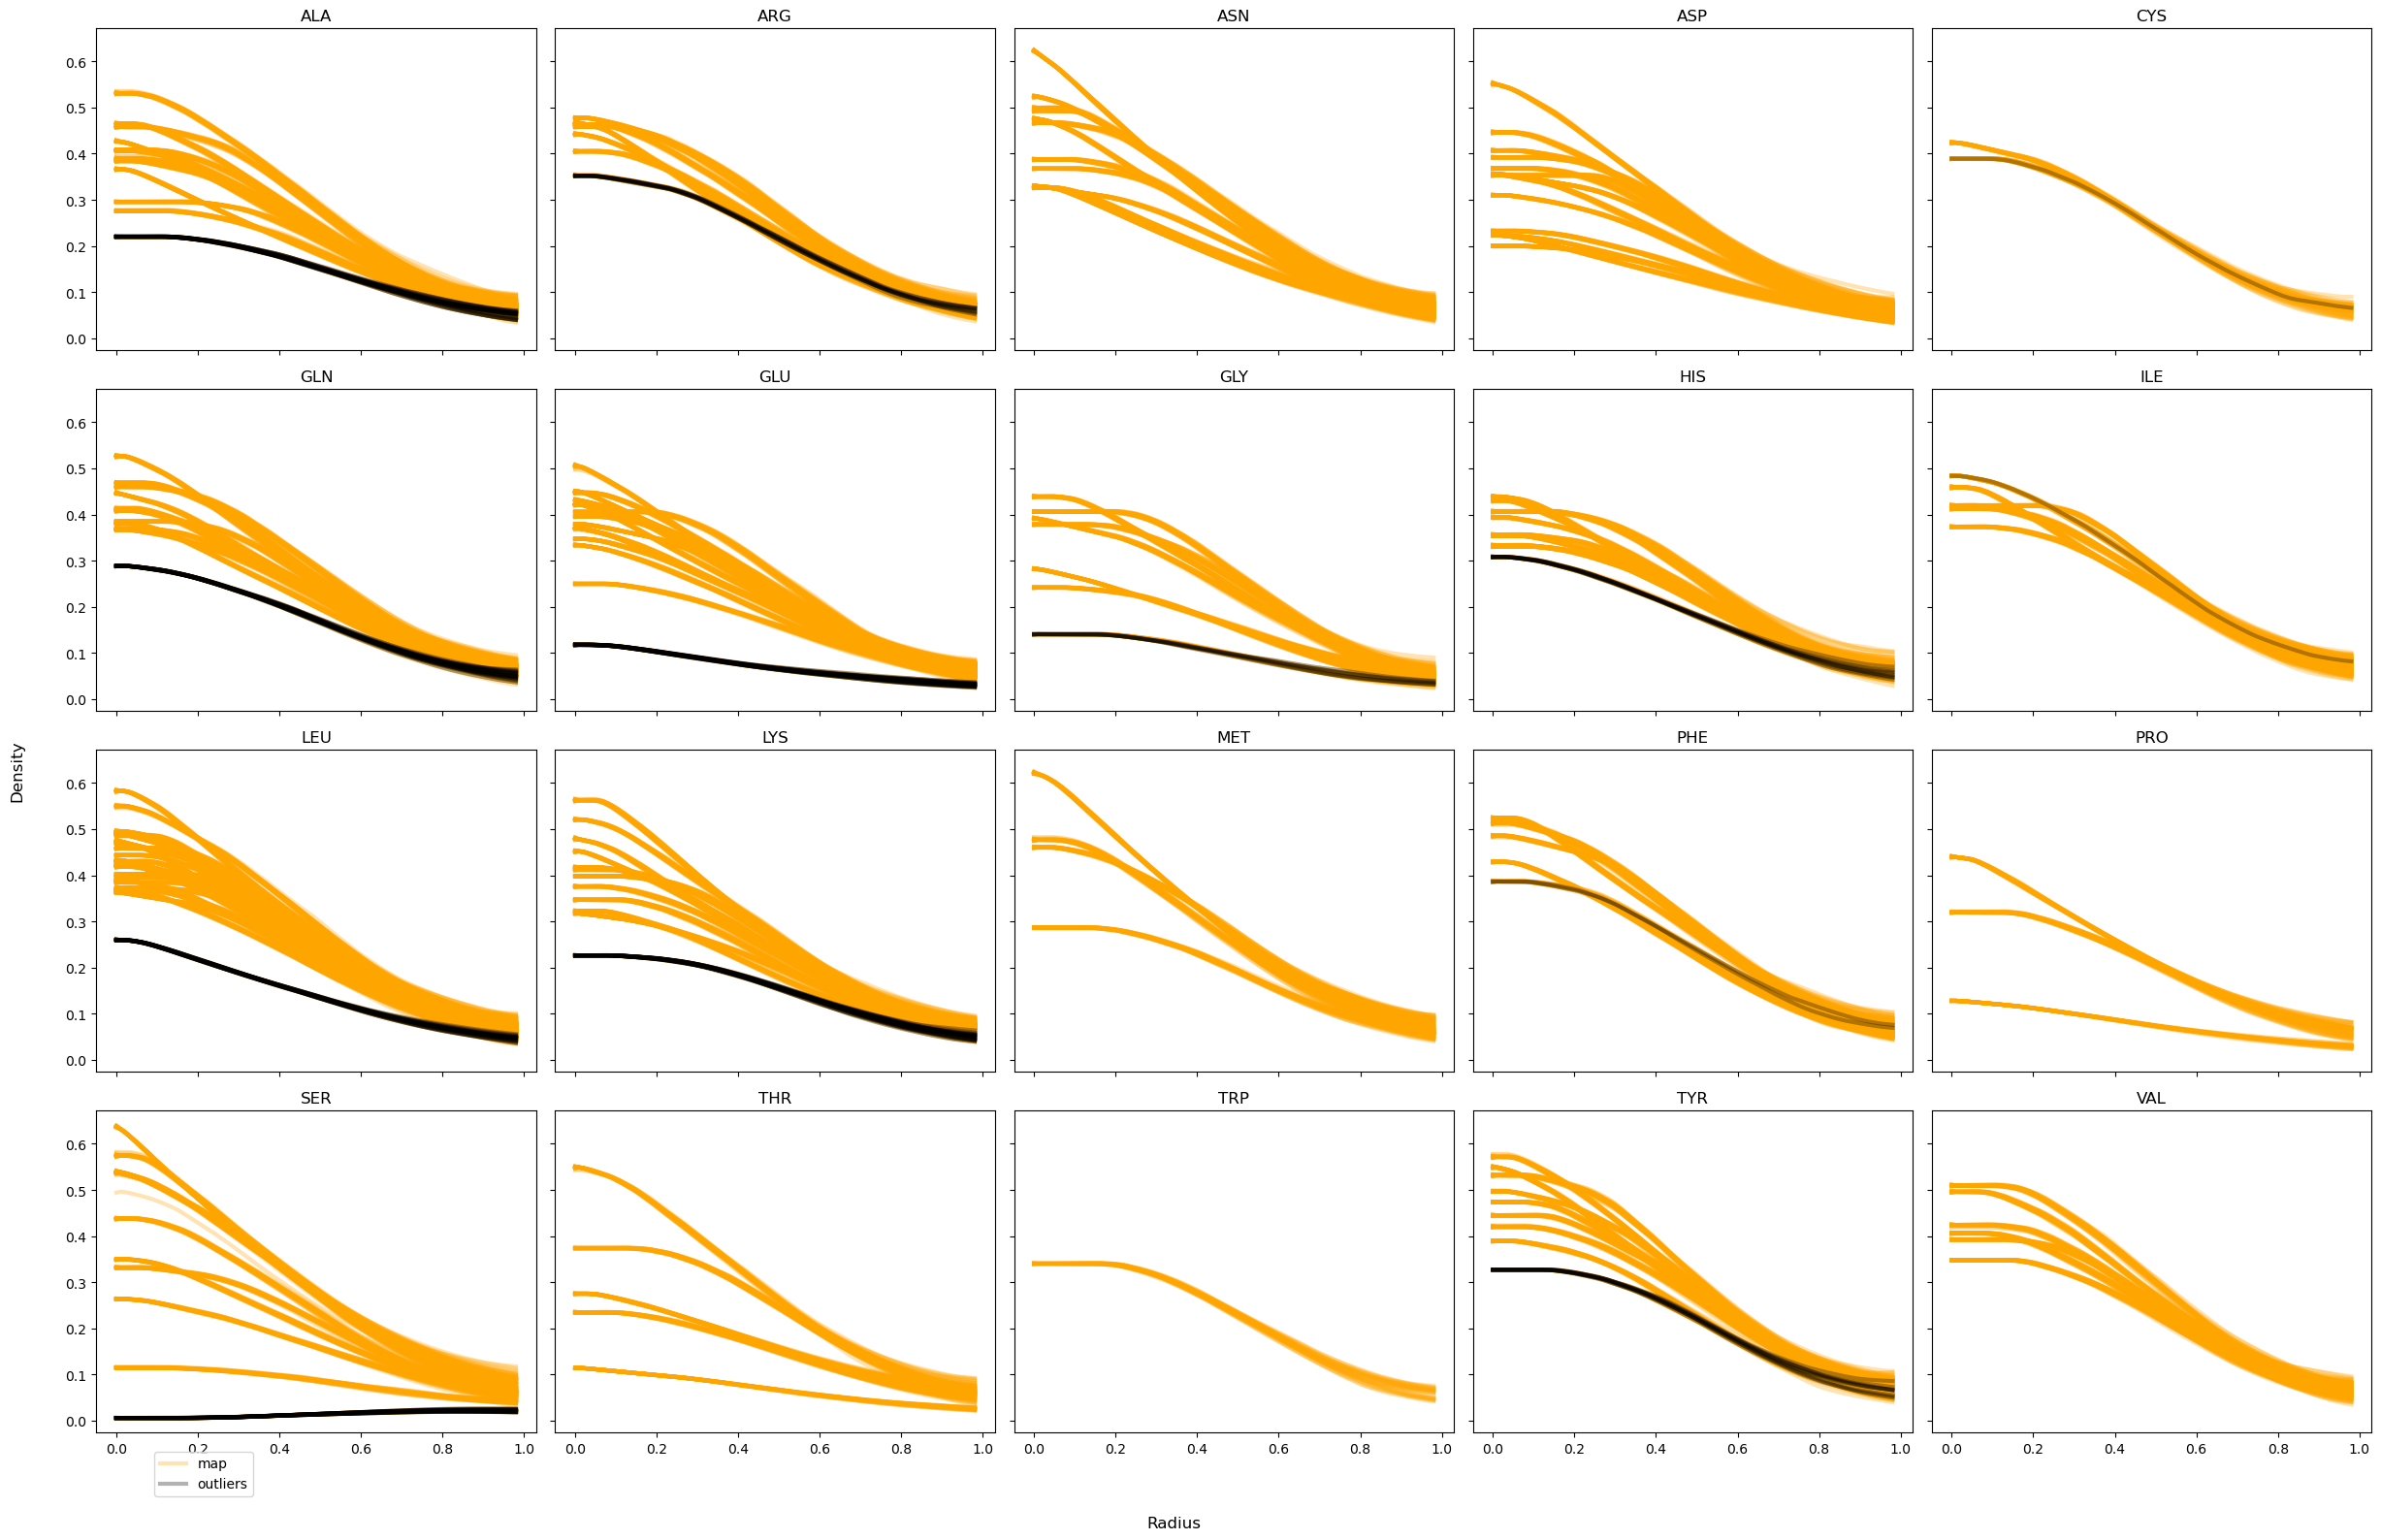

In [ ]:

max_radius = 1
gap = 0.01
subplots_num = len(densities_outliers)
nums = int(subplots_num / 5) + 1 if subplots_num % 5 != 0 else int(subplots_num / 5)
fig, axes = plt.subplots(nums, 5, figsize=(25, nums * 4), sharex=True, sharey=True, squeeze=False)
x = np.arange(0, max_radius - gap, gap)
length = len(x)

for times, name in enumerate(densities_outliers): 
    i = times // 5
    j = times % 5
    for density in wqeb.densities_data[name]:
        axes[i][j].plot(x, density[:length], linewidth=3, alpha=0.3, c="orange", label="map")
    for density_outliers in densities_outliers[name]:
        axes[i][j].plot(x, density_outliers[:length], linewidth=3, alpha=0.3, c="black", label="outliers")
    axes[i][j].set_title(name)

labels_handles = {
label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
}

fig.legend(
labels_handles.values(),
labels_handles.keys(),
loc = "upper center",
bbox_to_anchor = (0.1, 0.065),
bbox_transform = plt.gcf().transFigure,
)
fig.supxlabel('Radius')
fig.supylabel('Density')
plt.tight_layout()
fig.tight_layout(rect=(0.025, 0.03, 1, 1))
fig.savefig("../figures/outliers_beta0.png")

In [ ]:
from scipy.stats import multivariate_normal, chi2
outliers = {}
statistic_distances = {}
_, margin = chi2.interval(0.95, 1)
# margin = 1
for name in wqeb.betas_weighted:
    outliers[name] = []
    statistic_distances[name] = []
    sigmas = wqeb.sigmas_median[name] 
    mean = wqeb.mus_mle[name]
    betas = wqeb.betas_weighted[name]
    lambdas = wqeb.lambdas[name]
    weight_matrixs = wqeb.weight_matrixs[name]
    datas_density = wqeb.densities_data[name]
    estimated_density = wqeb.densities_betas_weighted[name]
    mle_density = wqeb.densities_mle[name]
    # sigma_matrix = np.sum([lambdas[i] * (betas - mean)[i].reshape(-1, 1) @ (betas - mean)[i].reshape(-1, 1).T for i in range(len(betas))], axis=0) / np.sum(lambdas) 
    sigma_matrix = np.sum([(betas - mean)[i][1] ** 2 for i in range(len(betas))]) / (len(betas) - 1)
    for i in range(len(betas)):
        # sigma_matrix = wqeb.sigmas_median[name][i] * np.eye(len(mle_density))
        # sigma_matrix = sigmas[i] * weight_matrixs[i]
        
        statistic_distance = (betas - mean)[i][1] ** 2 / sigma_matrix
        # Z = (mle_density - datas_density[i]).reshape(-1, 1)
        # Z = (datas[i] - np.exp(X @ mean)).reshape(-1, 1)
        # statistic_distance = (Z.T @ Z).flatten() 
        # statistic_distance = (betas[i] - mean).T @np.linalg.inv(sigma[i] * np.eye(2)) @ (betas[i] - mean)
        statistic_distances[name].append(np.round(statistic_distance, 2))
        if statistic_distance > margin:
            outliers[name].append(i)

In [ ]:
densities_outliers = {}
for name in wqeb.densities_data:
    densities_outliers[name] =wqeb.densities_data[name][outliers[name]]

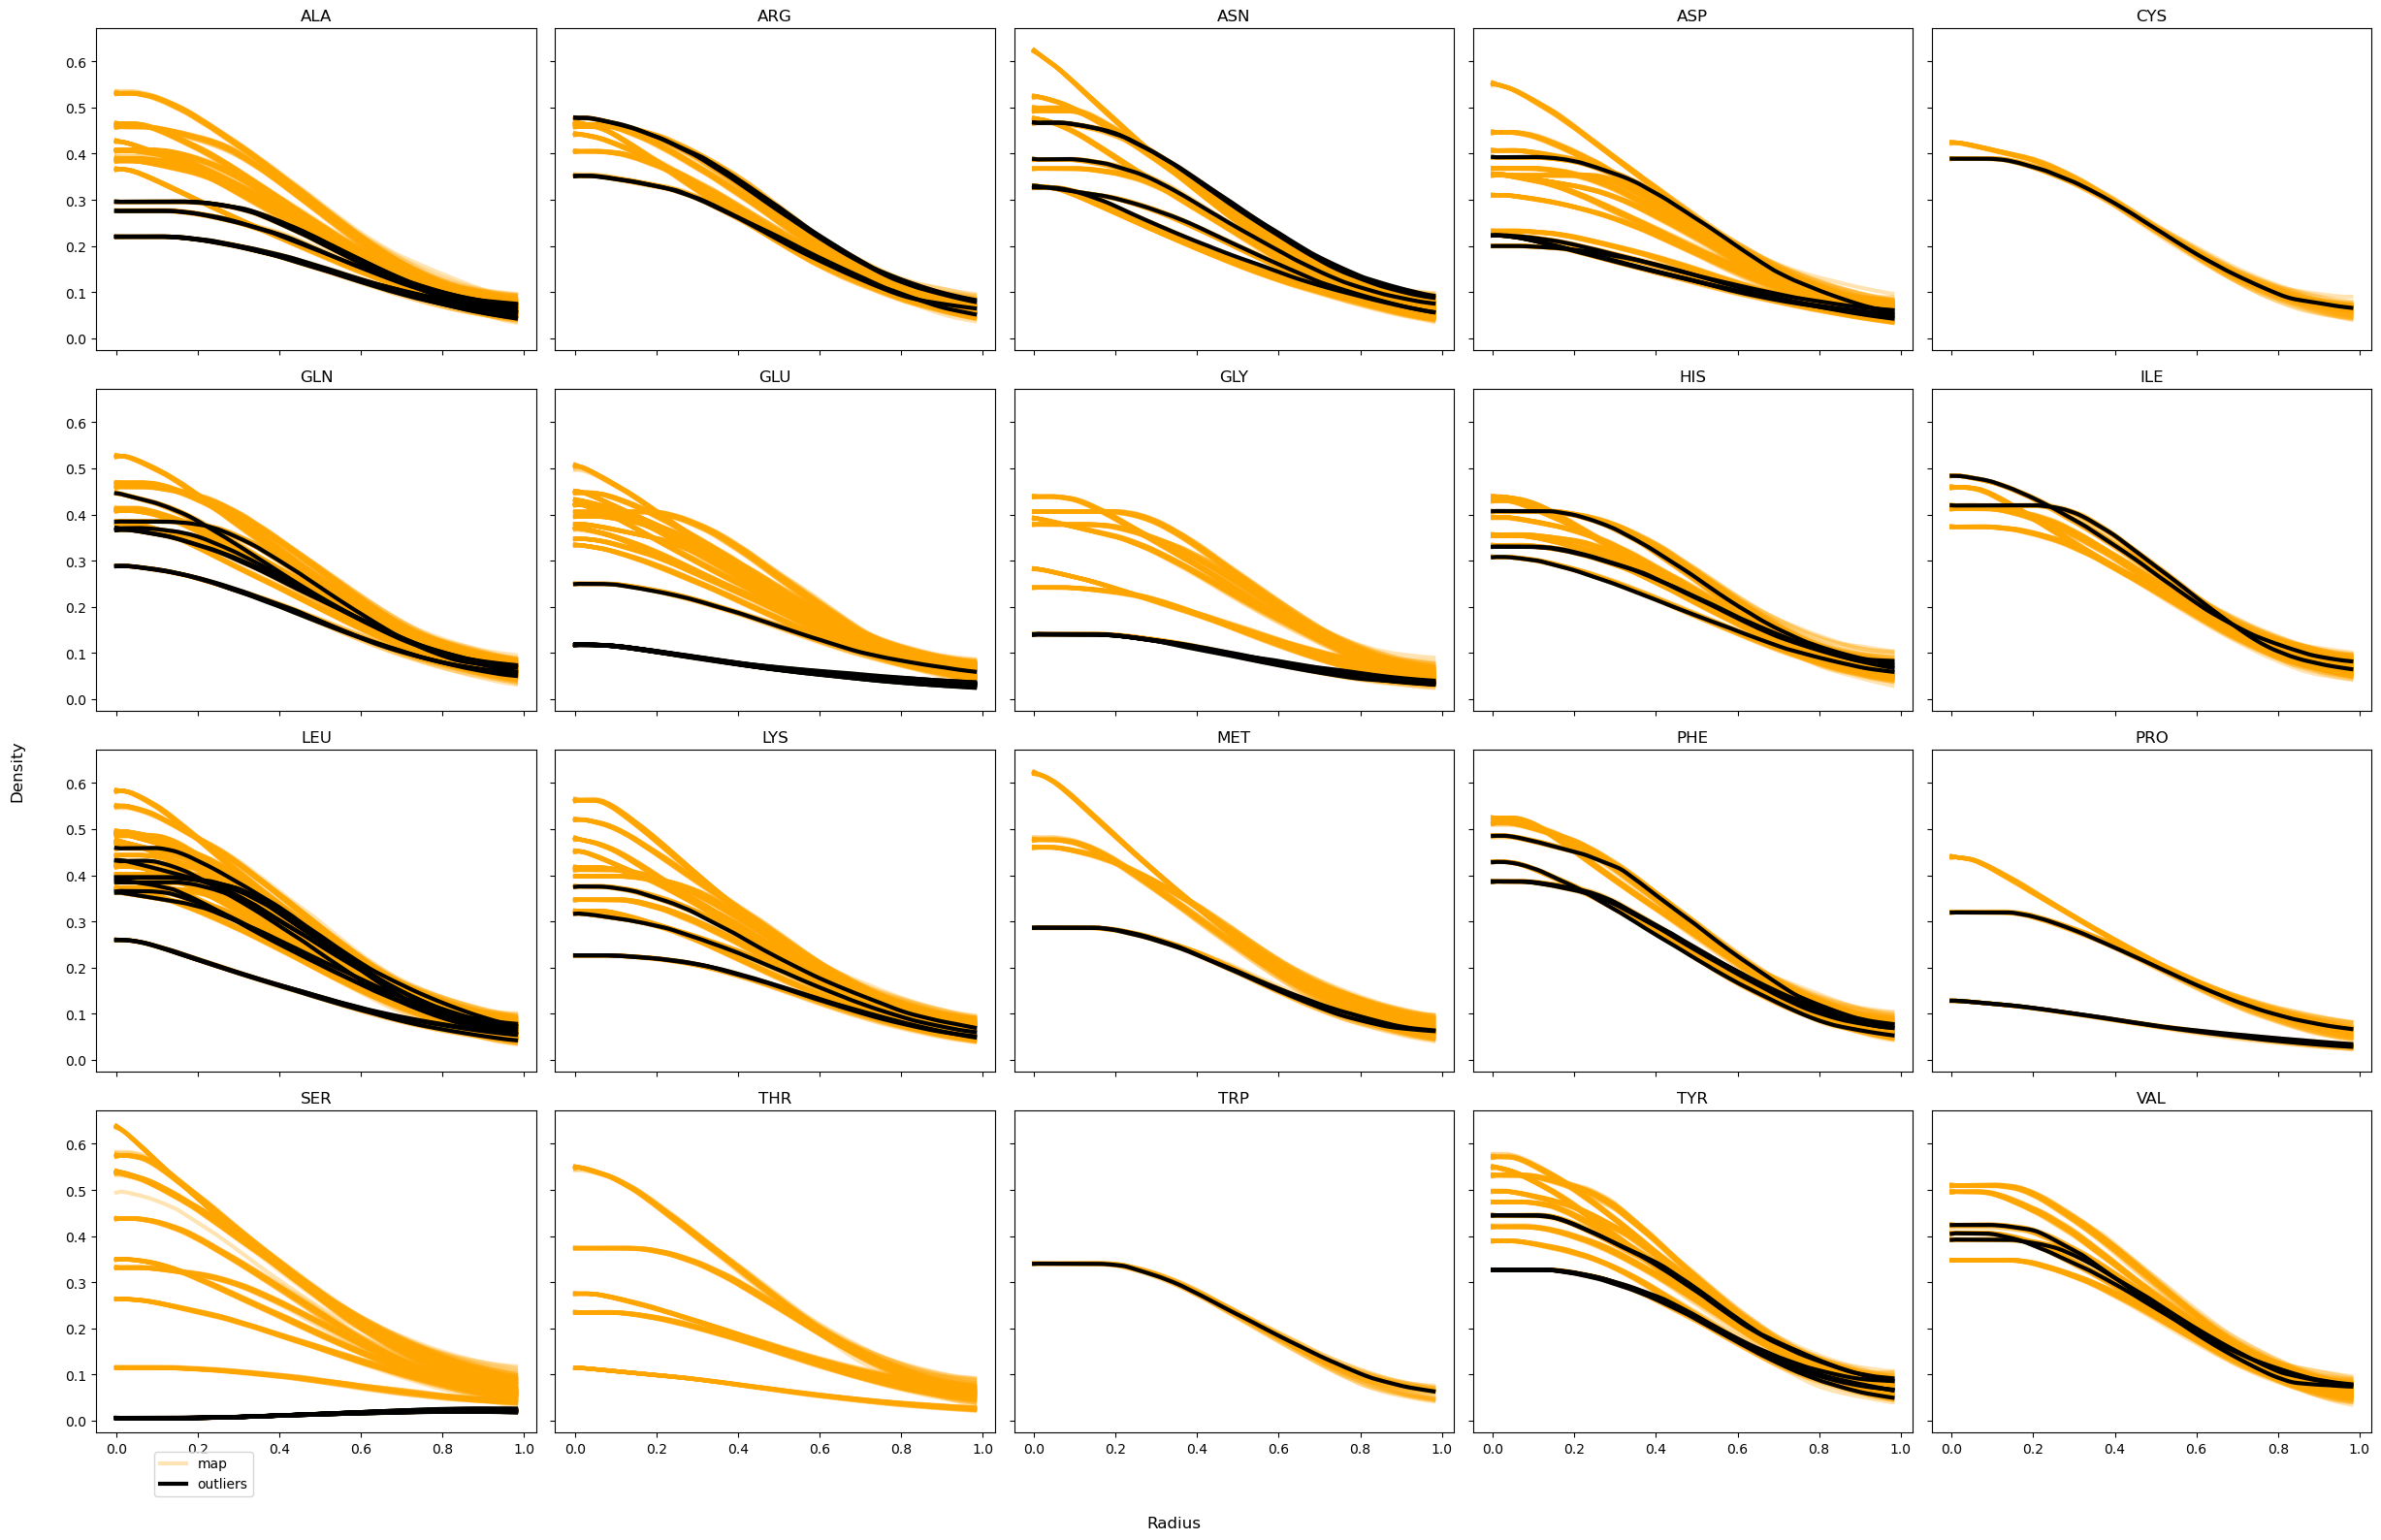

In [ ]:

max_radius = 1
gap = 0.01
subplots_num = len(densities_outliers)
nums = int(subplots_num / 5) + 1 if subplots_num % 5 != 0 else int(subplots_num / 5)
fig, axes = plt.subplots(nums, 5, figsize=(25, nums * 4), sharex=True, sharey=True, squeeze=False)
x = np.arange(0, max_radius - gap, gap)
length = len(x)

for times, name in enumerate(densities_outliers): 
    i = times // 5
    j = times % 5
    for density in wqeb.densities_data[name]:
        axes[i][j].plot(x, density[:length], linewidth=3, alpha=0.3, c="orange", label="map")
    for density_outliers in densities_outliers[name]:
        axes[i][j].plot(x, density_outliers[:length], linewidth=3, alpha=1, c="black", label="outliers")
    axes[i][j].set_title(name)

labels_handles = {
label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
}

fig.legend(
labels_handles.values(),
labels_handles.keys(),
loc = "upper center",
bbox_to_anchor = (0.1, 0.065),
bbox_transform = plt.gcf().transFigure,
)
fig.supxlabel('Radius')
fig.supylabel('Density')
plt.tight_layout()
fig.tight_layout(rect=(0.025, 0.03, 1, 1))
fig.savefig("../figures/outliers_beta1.png")

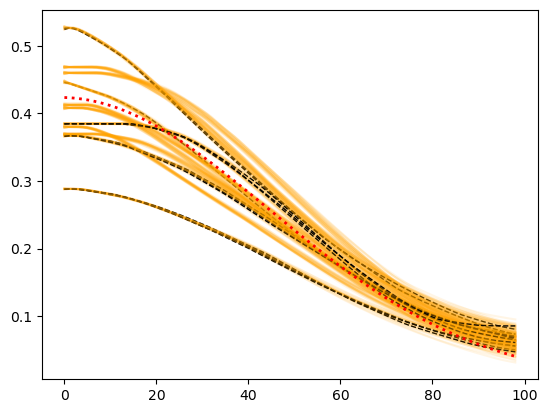

In [ ]:
name = "GLN"
outliers[name]
for idx, density in enumerate(wqeb.densities_data[name]):
    if idx in outliers[name]:
        plt.plot(density, color="black", linewidth=1, linestyle="--")
    else:
        plt.plot(density, color="orange", alpha=0.1)
        
plt.plot(wqeb.densities_mle[name], color="red", linewidth=2, linestyle=":")

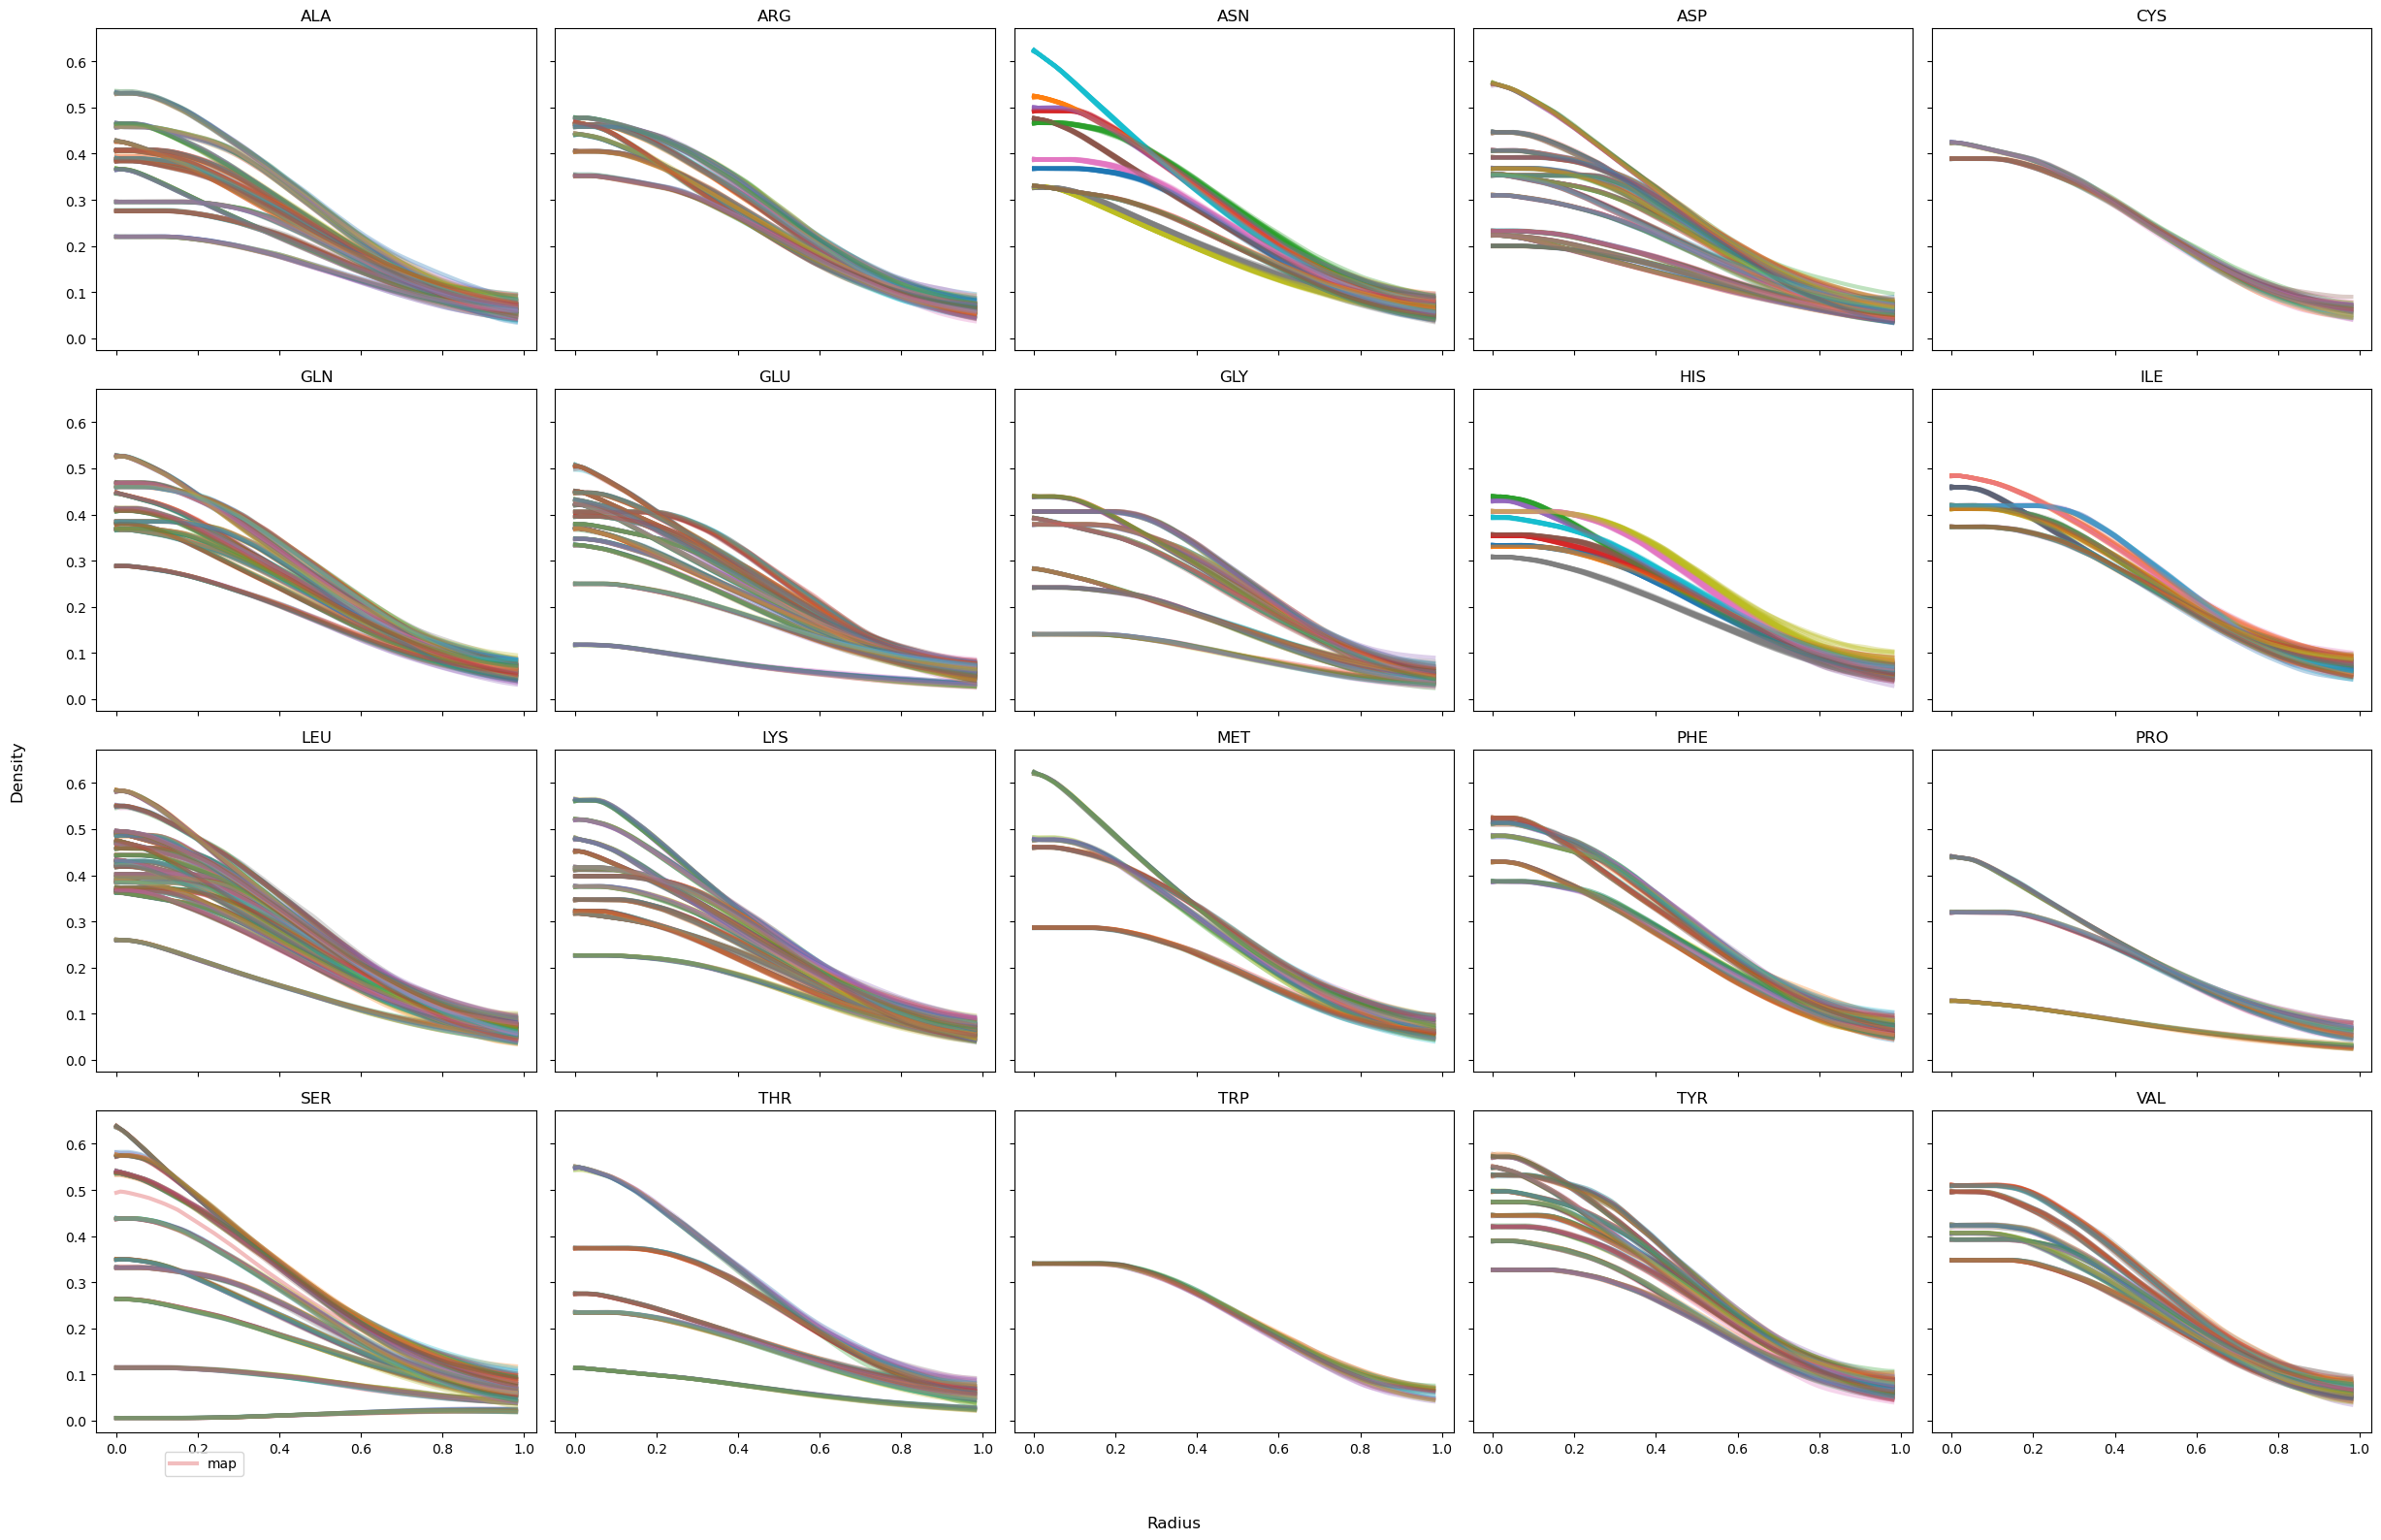

In [ ]:

max_radius = 1
gap = 0.01
subplots_num = len(densities_outliers)
nums = int(subplots_num / 5) + 1 if subplots_num % 5 != 0 else int(subplots_num / 5)
fig, axes = plt.subplots(nums, 5, figsize=(25, nums * 4), sharex=True, sharey=True, squeeze=False)
x = np.arange(0, max_radius - gap, gap)
length = len(x)

for times, name in enumerate(densities_outliers): 
    i = times // 5
    j = times % 5
    for density in wqeb.densities_data[name]:
        axes[i][j].plot(x, density[:length], linewidth=3, alpha=0.3, label="map")
    axes[i][j].set_title(name)

labels_handles = {
label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
}

fig.legend(
labels_handles.values(),
labels_handles.keys(),
loc = "upper center",
bbox_to_anchor = (0.1, 0.065),
bbox_transform = plt.gcf().transFigure,
)
fig.supxlabel('Radius')
fig.supylabel('Density')
plt.tight_layout()
fig.tight_layout(rect=(0.025, 0.03, 1, 1))
fig.savefig("../figures/density_maps.png")

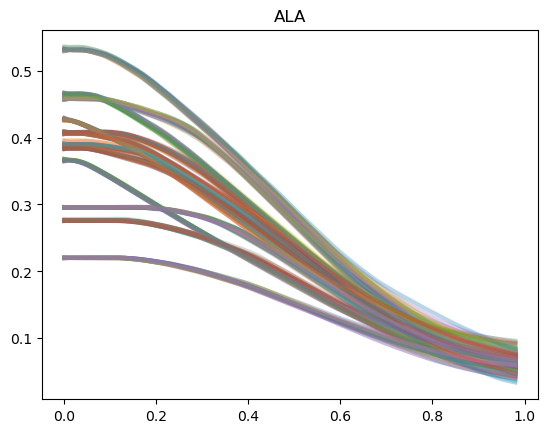

In [ ]:
name = "ALA"
for density in wqeb.densities_data[name]:
    plt.plot(x, density[:length], linewidth=3, alpha=0.3)
plt.title(name)
plt.savefig(f"../figures/density_map_{name}.png")

In [ ]:
wqeb.betas_em["GLN"][outliers["GLN"]][0]

array([-0.78338825,  6.66816507])

In [ ]:
wqeb.betas_em["GLN"]

array([[-1.0139838 ,  4.52173456],
       [-0.89704547,  4.50200053],
       [-1.21484996,  4.47525739],
       [-0.783088  ,  4.53715697],
       [-0.91081542,  3.78602292],
       [-0.75890519,  4.5660079 ],
       [-0.74092094,  4.44075329],
       [-0.89534255,  4.48324699],
       [-0.97058491,  4.48333729],
       [-0.95009936,  4.48904999],
       [-0.92728206,  4.48521547],
       [-0.99751532,  4.50882164],
       [-0.88413036,  4.50732935],
       [-1.21980794,  4.43444765],
       [-0.74677551,  4.42940086],
       [-0.87961197,  4.46826182],
       [-0.7401542 ,  4.50813116],
       [-0.72200832,  4.39223484],
       [-0.89389683,  4.48675903],
       [-0.96446178,  4.47903889],
       [-0.96423904,  4.4992755 ],
       [-0.94217111,  4.48662708],
       [-0.99690953,  4.49000174],
       [-0.78338825,  6.66816507],
       [-1.26859847,  3.57192797],
       [-0.75295536,  4.43079224],
       [-0.88841495,  4.47972779],
       [-0.75295603,  4.56471804],
       [-0.74187096,

In [ ]:
wqeb.densities_estimated["GLN"][0]

array([0.36268888, 0.36244297, 0.36203348, 0.36146098, 0.36072623,
       0.35983024, 0.3587742 , 0.35755955, 0.35618792, 0.35466114,
       0.35298127, 0.35115053, 0.34917137, 0.3470464 , 0.34477842,
       0.34237043, 0.33982555, 0.33714711, 0.33433857, 0.33140354,
       0.32834577, 0.32516915, 0.32187768, 0.31847549, 0.31496681,
       0.31135597, 0.30764738, 0.30384554, 0.29995502, 0.29598045,
       0.29192652, 0.28779795, 0.2835995 , 0.27933596, 0.27501214,
       0.27063284, 0.26620289, 0.26172707, 0.25721018, 0.25265697,
       0.24807216, 0.24346045, 0.23882644, 0.23417474, 0.22950983,
       0.22483616, 0.22015809, 0.2154799 , 0.21080578, 0.20613982,
       0.201486  , 0.19684822, 0.19223025, 0.18763575, 0.18306827,
       0.17853122, 0.17402791, 0.16956151, 0.16513504, 0.16075143,
       0.15641344, 0.15212371, 0.14788475, 0.14369891, 0.13956843,
       0.1354954 , 0.13148176, 0.12752934, 0.12363981, 0.11981472,
       0.11605547, 0.11236336, 0.10873952, 0.10518498, 0.10170

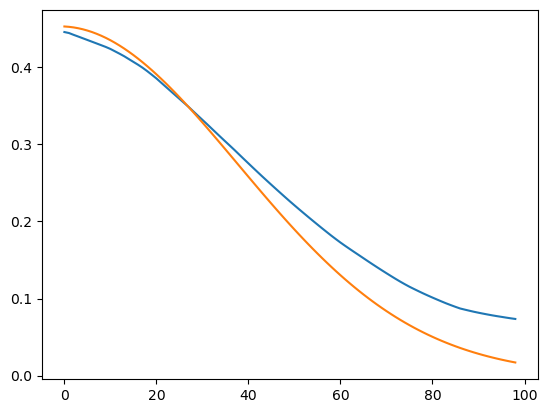

In [ ]:
name = "GLN"
plt.plot(wqeb.densities_data[name][outliers[name][0]])
plt.plot(wqeb.densities_estimated[name][outliers[name][0]])

In [ ]:
# chosen_densities = wqeb.densities_data[name][outliers[name]]
# chosen_estimated_densities = dm[name][outliers[name]]
# chosen_num = int(len(chosen_estimated_densities) / 5)
# fig, axes = plt.subplots(chosen_num + 1, 5, figsize=(20, chosen_num * 5), sharex=True, sharey=True,  squeeze=False)
# for times, elements in enumerate(zip(chosen_densities, chosen_estimated_densities)):
#     chosen_density, chosen_estimated_density = elements
#     i = times // 5
#     j = times % 5
#     axes[i][j].plot(chosen_density)
#     axes[i][j].plot(chosen_estimated_density)

In [ ]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# i = 0
# for name, outlier_all in outliers.items():
#     for outlier in outlier_all:
#         axes[i].plot(wqeb.weighted_estimated_radius_density[name][outlier], "-.", label="WEB estimate")
#         axes[i].plot(wqeb.radius_density[name][outlier], label="density map")
#         axes[i].text(i*1.2 + 0.3, 0.5, f'Statistic Distances: \n{statistic_distances[name][outlier]} >{np.round(margin, 2)}', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)
#         axes[i].title.set_text(name)
#         axes[i].legend()
#         i += 1
# plt.show()

In [ ]:
wqeb.weighted_estimated_radius_density[name]

4.692166657053904

In [ ]:
qscores_all = {}
for name in wqeb.densities_data:
    qscores = []
    for data_density, estimated_density in zip(wqeb.densities_data[name], dm[name]):
        data_density = np.array(data_density)
        estimated_density = np.array(estimated_density)
        numerator = np.dot(data_density - data_density.mean(), estimated_density - estimated_density.mean())
        denominator = np.sqrt(sum((data_density - data_density.mean())**2)) * np.sqrt(sum((estimated_density - estimated_density.mean())**2))
        qscores.append(numerator / denominator)
    qscores_all[name] = qscores

In [ ]:
# for name in qscores_all:
#     result = pd.DataFrame(qscores_all[name], columns=[name]) [(pd.DataFrame(qscores_all[name], columns=[name]) < 0.95).values.flatten()]
#     if len(result) > 0:
#         for idx, i in enumerate(result.index):
#             print(result.iloc[idx, :])
#             plt.plot(wqeb.densities_data[name][result.index[idx]])
#             plt.plot(dm[name][result.index[idx]])
#             plt.show()
#     else:
#         print(f"{name} has no lower qscore")

In [ ]:
dfs = [pd.DataFrame(qscores_all[name], columns=[name]) for name in qscores_all]

In [ ]:
max_num = max([len(qscores) for qscores in qscores_all.values()])
for qscores in qscores_all:
    qscores_all[qscores] = qscores_all[qscores] + [0] * (max_num - len(qscores_all[qscores]))

In [ ]:
pd.DataFrame(qscores_all)

ALA       ARG       ASN       ASP       CYS       GLN       GLU  \
0    0.988510  0.997775  0.994321  0.999472  0.999618  0.997579  0.999113   
1    0.999061  0.999708  0.998914  0.997412  0.997454  0.997603  0.991667   
2    0.998362  0.997260  0.999184  0.994368  0.999623  0.999913  0.999445   
3    0.998305  0.999476  0.997878  0.989547  0.997722  0.999299  0.998186   
4    0.999086  0.999601  0.998866  0.995033  0.999314  0.997969  0.993462   
..        ...       ...       ...       ...       ...       ...       ...   
523  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
524  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
525  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
526  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
527  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          GLY       HIS       ILE       LEU       LYS       MET       PHE  \
0    0.993505  0.998377  0.996260  0.999334  0.994895  0.991201  0.997054   
1    0.999520  0.997600  0.999388  0.999784  0.998206  0.998177  0.997929   
2    0.999655  0.994664  0.999000  0.999725  0.999539  0.999108  0.999163   
3    0.989935  0.999213  0.998308  0.999121  0.999369  0.992849  0.999204   
4    0.997523  0.996856  0.987665  0.986518  0.998199  0.990254  0.998078   
..        ...       ...       ...       ...       ...       ...       ...   
523  0.000000  0.000000  0.000000  0.999663  0.000000  0.000000  0.000000   
524  0.000000  0.000000  0.000000  0.998714  0.000000  0.000000  0.000000   
525  0.000000  0.000000  0.000000  0.998845  0.000000  0.000000  0.000000   
526  0.000000  0.000000  0.000000  0.999756  0.000000  0.000000  0.000000   
527  0.000000  0.000000  0.000000  0.999230  0.000000  0.000000  0.000000   

          PRO       SER       THR       TRP       TYR       VAL  
0    0.998100  0.841654  0.993061  0.993581  0.998851  0.999122  
1    0.988817  0.999405  0.997806  0.994366  0.999587  0.998766  
2    0.997607  0.996047  0.994748  0.994245  0.996232  0.997679  
3    0.998067  0.997444  0.996937  0.994000  0.998679  0.996288  
4    0.989400  0.995735  0.998416  0.995473  0.996844  0.993822  
..        ...       ...       ...       ...       ...       ...  
523  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
524  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
525  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
526  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
527  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[528 rows x 20 columns]

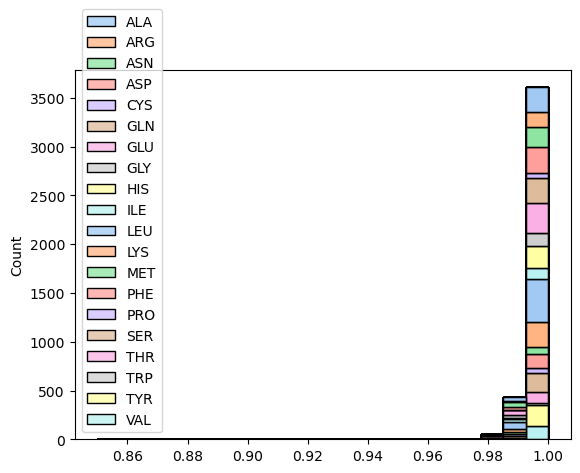

In [ ]:
import seaborn as sns
for df in dfs:
    sns.histplot(pd.DataFrame(qscores_all), binrange=(0.85, 1), stat="count", bins=20, multiple="stack", kde=False, palette="pastel", element="bars", legend=True)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   1.,
          0.,   0.,   1.,   0.,   2.,   0.,   3.,   2.,   5.,   4.,  13.,
          9.,  35.,  92.,  88., 121., 397.]),
 array([0.96775529, 0.96842639, 0.9690975 , 0.9697686 , 0.97043971,
        0.97111081, 0.97178192, 0.97245302, 0.97312413, 0.97379523,
        0.97446634, 0.97513745, 0.97580855, 0.97647966, 0.97715076,
        0.97782187, 0.97849297, 0.97916408, 0.97983518, 0.98050629,
        0.98117739, 0.9818485 , 0.9825196 , 0.98319071, 0.98386181,
        0.98453292, 0.98520402, 0.98587513, 0.98654623, 0.98721734,
        0.98788844, 0.98855955, 0.98923066, 0.98990176, 0.99057287,
        0.99124397, 0.99191508, 0.99258618, 0.99325729, 0.99392839,
        0.9945995 , 0.9952706 , 0.99594171, 0.99661281, 0.99728392,
        0.99795502, 0.99862613, 0.99929723, 0.

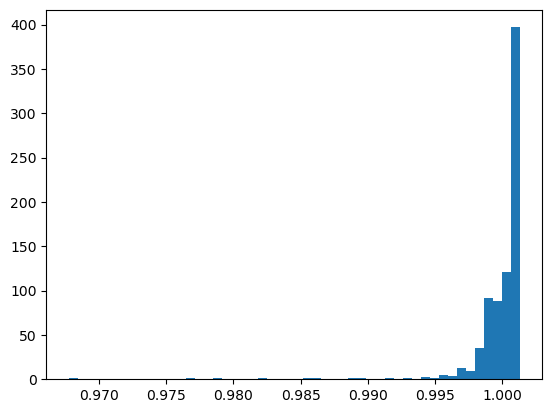

In [ ]:
plt.hist((np.diag(wqeb.weight_matrixs["SER"][0])), bins=50)

In [ ]:
import random
number_of_colors = 20
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])for i in range(number_of_colors)]
print(color)

['#74190E', '#A54EBC', '#122D69', '#DFC700', '#598A2F', '#89DCC1', '#5479A1', '#1FD4F2', '#4BD1EC', '#E13F40', '#14A3B6', '#CF31EA', '#394C93', '#61CEB6', '#EB211F', '#80672D', '#934DD2', '#3D23D4', '#0EDD0F', '#A82B23']


In [ ]:
wqeb.mus_mle["ALA"]

{'ALA': array([-0.87660058,  4.59262477]),
 'ARG': array([-0.78994986,  4.73026486]),
 'ASN': array([-0.71501642,  4.80958684]),
 'ASP': array([-0.9851642 ,  4.29383163]),
 'CYS': array([-0.87361586,  4.67492292]),
 'GLN': array([-0.91810809,  4.5990282 ]),
 'GLU': array([-0.92666652,  4.50355831]),
 'GLY': array([-0.8690076 ,  4.40636273]),
 'HIS': array([-0.98773511,  4.14517375]),
 'ILE': array([-0.82277876,  4.40198261]),
 'LEU': array([-0.81039186,  4.5692218 ]),
 'LYS': array([-0.97889209,  4.32631076]),
 'MET': array([-0.71419118,  4.94367685]),
 'PHE': array([-0.67838404,  4.59379179]),
 'PRO': array([-1.04663851,  4.27632024]),
 'SER': array([-1.08426796,  4.3563413 ]),
 'THR': array([-0.9143432,  4.1516018]),
 'TRP': array([-1.01104346,  3.88229404]),
 'TYR': array([-0.70272213,  4.51152423]),
 'VAL': array([-0.85555125,  4.46891164])}

In [ ]:
Counter(wqeb.Xs_tilde[name][i][:]).keys()

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
np.array(list(Counter(wqeb.Xs_tilde[name][i]).keys())).reshape(-1, 1)

TypeError: unhashable type: 'numpy.ndarray'

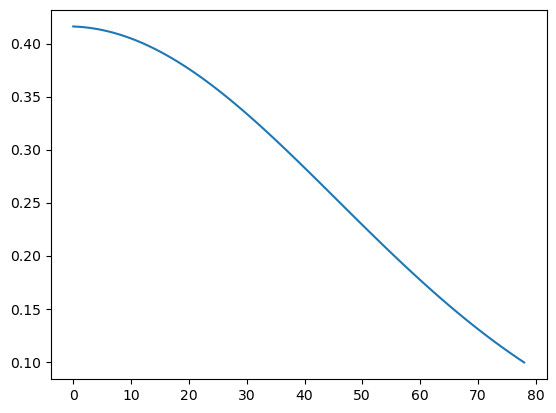

In [ ]:
name = "ALA"
i = 0
distance = np.array(list(Counter(wqeb.distances_to_center[name][i]).keys())).reshape(-1, 1)
X = np.concatenate((np.ones_like(distance), -1/2 * distance**2), axis=1)
plt.plot(np.exp(X @ wqeb.mus_mle[name]))

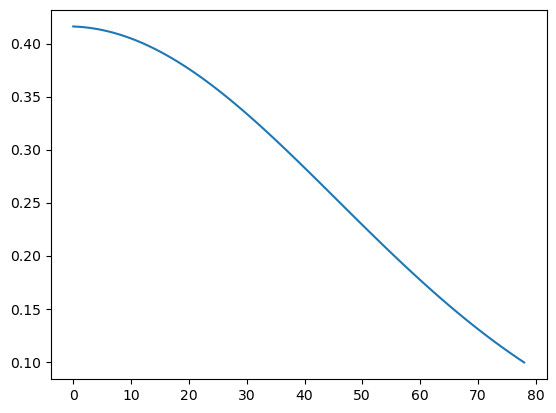

In [ ]:
plt.plot(np.exp(X @ wqeb.mus_mle[name]))

In [ ]:
np.sum(wqeb.betas_em[name] * np.repeat(wqeb.lambdas[name], 2).reshape(-1, 2), axis=0) / np.sum(wqeb.lambdas[name])

array([-0.84424106,  4.47301268])

In [ ]:
np.mus_mle[name]

AttributeError: module 'numpy' has no attribute 'mus_mle'

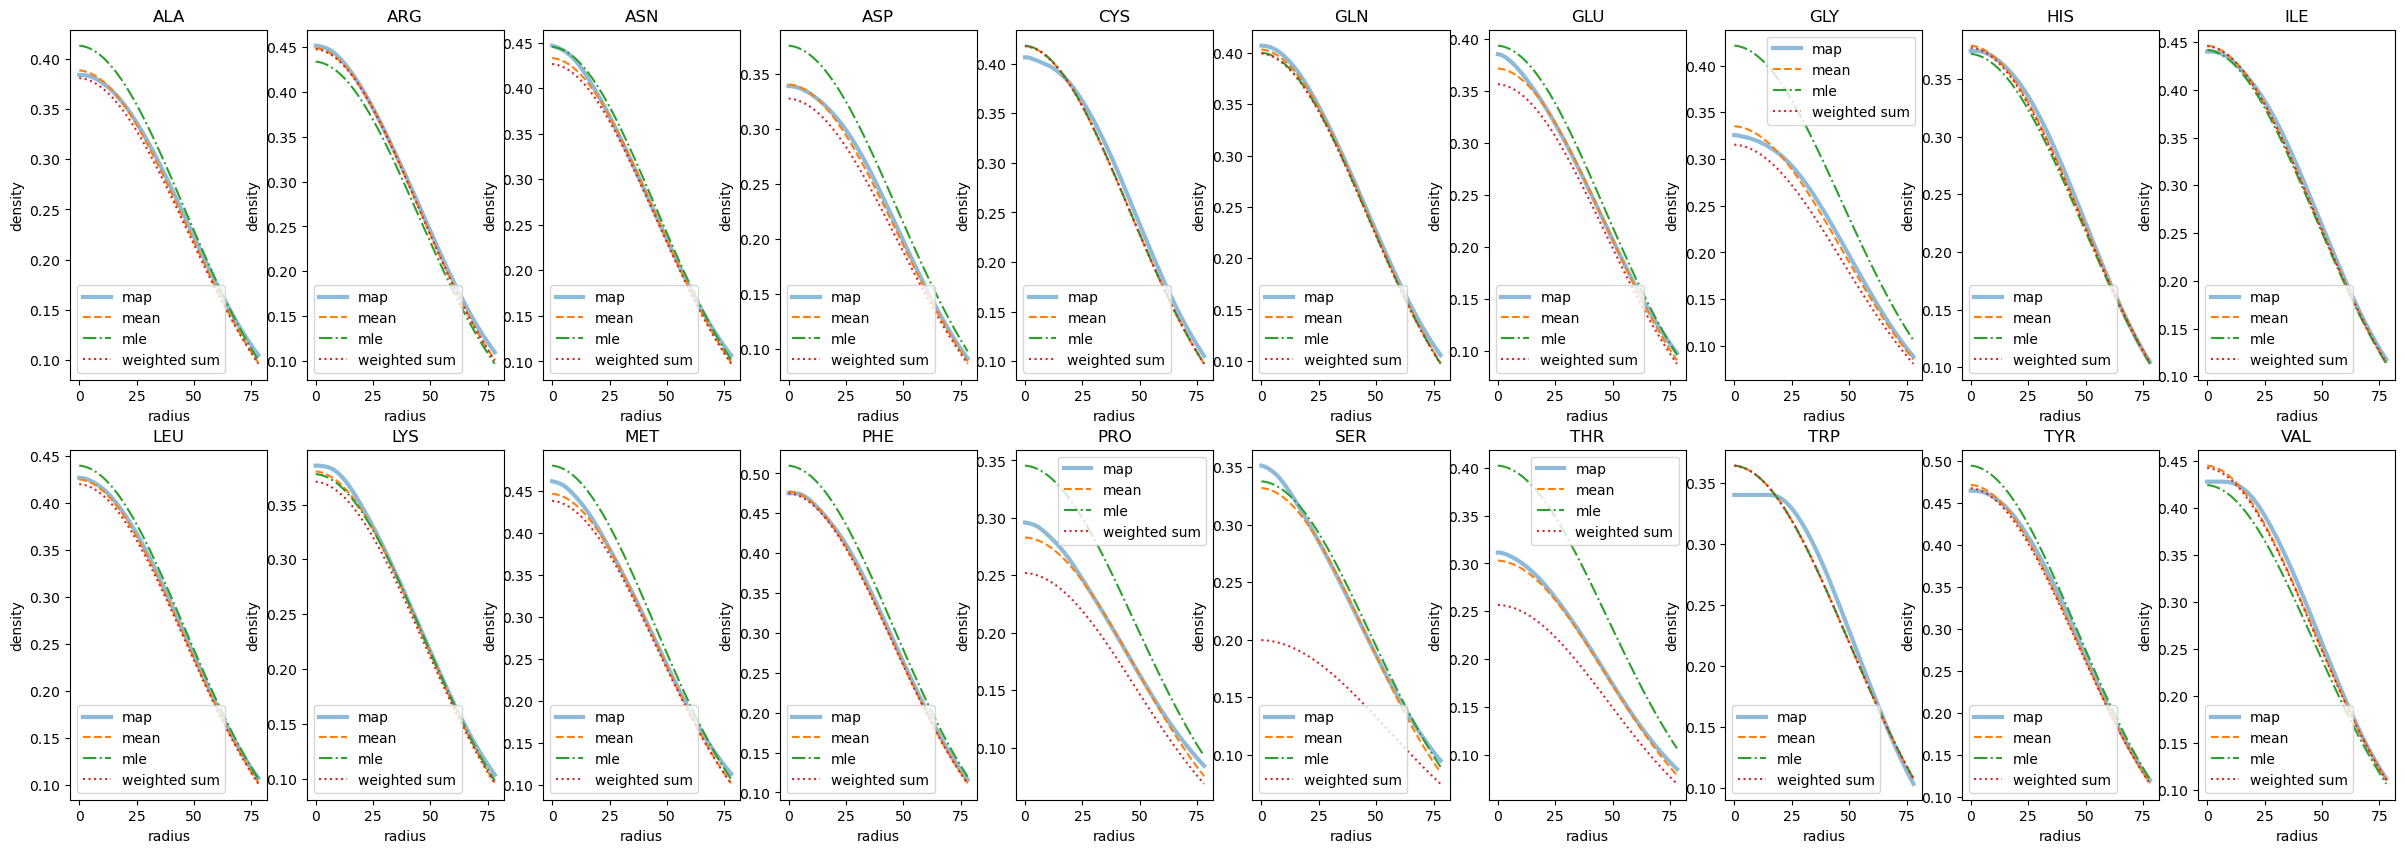

In [ ]:
# axes, fig = plt.subplots(10, 2, figsize=(10, 5))
import random
number_of_colors = 20
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])for i in range(number_of_colors)]
fig, axes = plt.subplots(2, 10, figsize=(30, 10))
for times, name in enumerate(wqeb.weighted_estimated_radius_density):
    # plt.figure(figsize=(8, 6))
    i = times // 10
    j = times % 10
    distance = np.array(list(Counter(wqeb.distances_to_center[name][0]).keys())).reshape(-1, 1)
    X = np.concatenate((np.ones_like(distance), -1/2 * distance**2), axis=1)
    weighted__betas_em = np.sum(wqeb.betas_em[name] * np.repeat(wqeb.lambdas[name], 2).reshape(-1, 2), axis=0) / np.sum(wqeb.lambdas[name])
    axes[i][j].plot(np.array(wqeb.radius_density[name]).mean(axis=0), label="map", linewidth=3, alpha=0.5)
    axes[i][j].plot(np.array(wqeb.weighted_estimated_radius_density[name]).mean(axis=0), label="mean", linestyle="--")
    axes[i][j].plot(np.exp(X @ wqeb.mus_mle[name]), label="mle", linestyle="-.")
    axes[i][j].plot(np.exp(X @ weighted__betas_em), label="weighted sum", linestyle=":")
    # plt.title(name)
    axes[i][j].set_xlabel("radius")
    axes[i][j].set_ylabel("density")
    axes[i][j].legend()
    axes[i][j].title.set_text(name)
plt.show()

In [ ]:
wqeb.mus_mle

{'ALA': array([-0.87660058,  4.59262477]),
 'ARG': array([-0.78994986,  4.73026486]),
 'ASN': array([-0.71501642,  4.80958684]),
 'ASP': array([-0.9851642 ,  4.29383163]),
 'CYS': array([-0.87361586,  4.67492292]),
 'GLN': array([-0.91810809,  4.5990282 ]),
 'GLU': array([-0.92666652,  4.50355831]),
 'GLY': array([-0.8690076 ,  4.40636273]),
 'HIS': array([-0.98773511,  4.14517375]),
 'ILE': array([-0.82277876,  4.40198261]),
 'LEU': array([-0.81039186,  4.5692218 ]),
 'LYS': array([-0.97889209,  4.32631076]),
 'MET': array([-0.71419118,  4.94367685]),
 'PHE': array([-0.67838404,  4.59379179]),
 'PRO': array([-1.04663851,  4.27632024]),
 'SER': array([-1.08426796,  4.3563413 ]),
 'THR': array([-0.9143432,  4.1516018]),
 'TRP': array([-1.01104346,  3.88229404]),
 'TYR': array([-0.70272213,  4.51152423]),
 'VAL': array([-0.85555125,  4.46891164])}

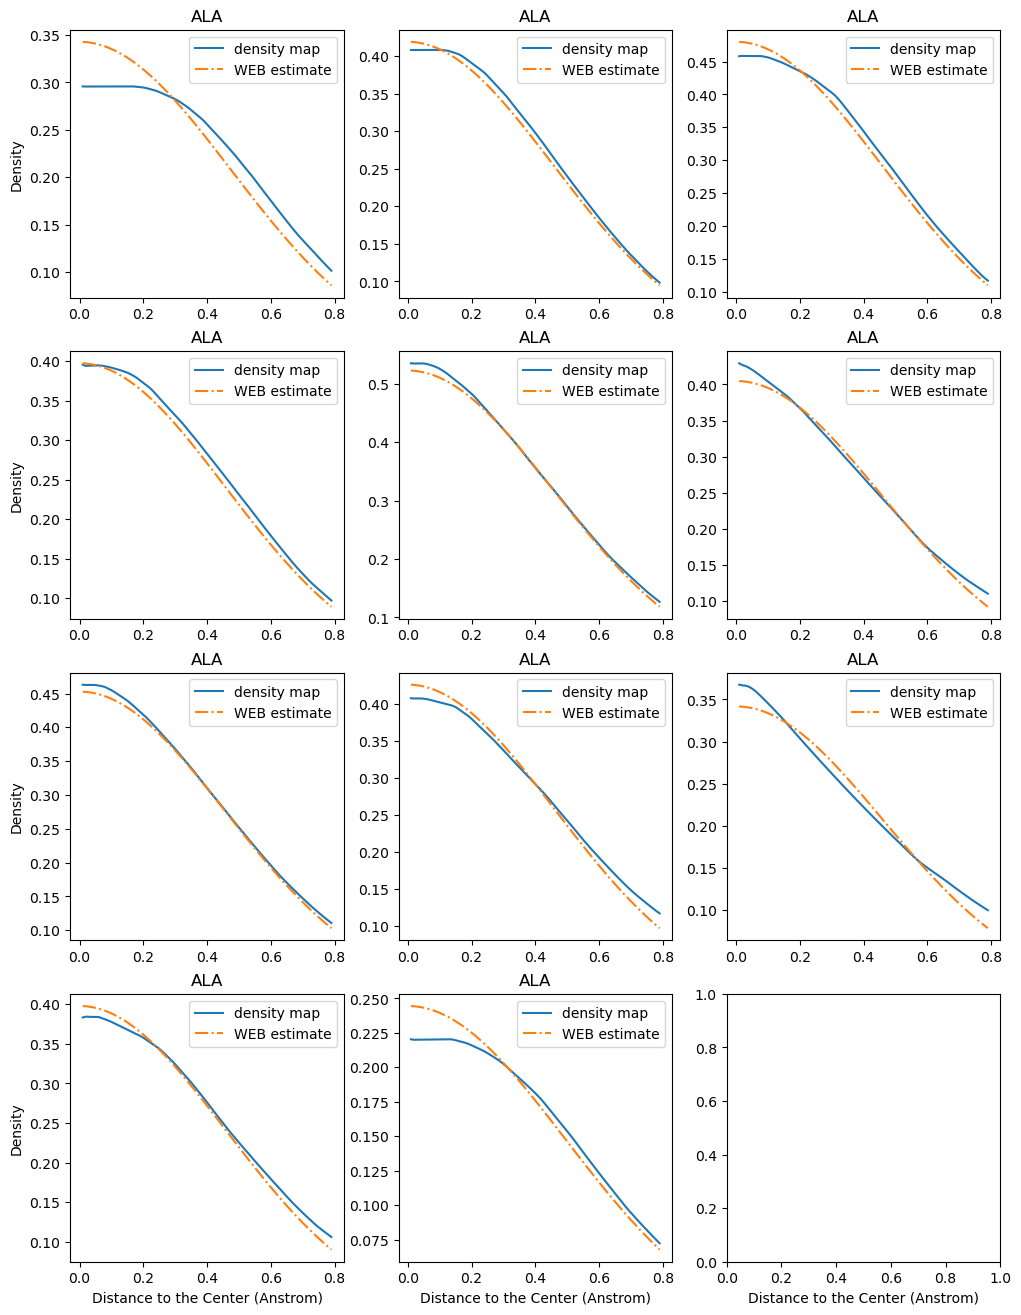

In [ ]:
wqeb.plot_data(max_rad=MAX_RAD, amino_acid="ALA")

In [ ]:
wqeb.lambdas

{'ALA': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'ARG': array([1., 1., 1., 1., 1., 1.]),
 'ASN': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'ASP': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'CYS': array([1., 1.]),
 'GLN': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'GLU': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'GLY': array([1., 1., 1., 1., 1., 1.]),
 'HIS': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'ILE': array([1., 1., 1., 1., 1.]),
 'LEU': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.]),
 'LYS': array([1., 1., 1., 1., 1., 1., 1., 1.]),
 'MET': array([1., 1., 1., 1.]),
 'PHE': array([1., 1., 1., 1., 1.]),
 'PRO': array([1., 1., 1.]),
 'SER': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'THR': array([1., 1., 1.]),
 'TRP': array([1.]),
 'TYR': array([1., 1., 1., 1., 1., 1., 1., 1.]),
 'VAL': array([1., 1., 1., 1., 1., 1.])}

In [ ]:
np.sum([np.diag(weight_matrix) for weight_matrix in wqeb.weight_matrixs["ARG"]], axis=1)

array([ 9.64056906, 10.30311278, 16.26903541,  6.88385489,  9.74026675,
        4.78045152])

In [ ]:
sum(np.diag(wqeb.weight_matrixs["ARG"][0]))

14.771551040153259

In [ ]:
wqeb.lambdas["ALA"]

array([9.86910618e-03, 7.21454557e-01, 8.80831148e+01, 2.81393345e-03,
       2.10461944e+01, 5.47358245e+02, 1.99384146e+02, 2.51712815e-01,
       3.97569654e+01, 6.55253284e+02, 4.32358810e-01])

In [ ]:
sum(np.diag(wqeb.weight_matrixs["ALA"][0]))

11085.148740234481

(array([ 27.,  27.,  30.,  42.,  83.,  63., 123., 106.,  79., 200.]),
 array([1.24477225e-10, 4.07131907e-03, 8.14263801e-03, 1.22139569e-02,
        1.62852759e-02, 2.03565948e-02, 2.44279138e-02, 2.84992327e-02,
        3.25705516e-02, 3.66418706e-02, 4.07131895e-02]),
 <BarContainer object of 10 artists>)

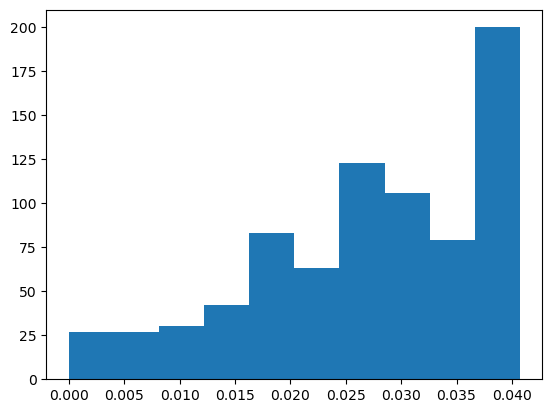

In [ ]:
plt.hist(np.diag(wqeb.weight_matrixs["ALA"][0]))

In [ ]:
wqeb.sigmas_median

{'ALA': array([[0.08296717],
        [0.00600139],
        [0.02039314],
        [0.01844067],
        [0.06198955],
        [0.01429305],
        [0.0129889 ],
        [0.01145318],
        [0.04682179],
        [0.01050427],
        [0.24638906]]),
 'ARG': array([[0.01342249],
        [0.01676857],
        [0.02634037],
        [0.01009092],
        [0.01643886],
        [0.00694597]]),
 'ASN': array([[0.01168207],
        [0.03012414],
        [0.02851927],
        [0.0271333 ],
        [0.0253392 ],
        [0.00386329],
        [0.02136898],
        [0.09683823],
        [0.11144845],
        [0.04235467]]),
 'ASP': array([[0.00415755],
        [0.11128924],
        [0.04922485],
        [0.03801172],
        [0.06412251],
        [0.1468876 ],
        [0.18449686],
        [0.08632697],
        [0.1081827 ],
        [0.03019127],
        [0.01896297],
        [0.05295359]]),
 'CYS': array([[0.00710726],
        [0.00763726]]),
 'GLN': array([[0.01800528],
        [0.00906062],
  